In [2]:
from itertools import cycle

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from scipy import interp
from scipy.stats import norm

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection._split import _BaseKFold
from sklearn.metrics import roc_curve, classification_report, log_loss, accuracy_score, auc
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

import pyfolio as pf

/home/agustin/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


## Importamos modulos auxiliares

In [3]:
# %load ../mpfin.py
import multiprocessing as mp
import datetime as dt
import time
import sys

def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    multiprocessing snippet [20.7]
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func

    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)

    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out


def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

def nestedParts(numAtoms,numThreads,upperTriang=False):
    # partition of atoms with an inner loop
    parts,numThreads_=[0],min(numThreads,numAtoms)
    for num in range(numThreads_):
        part=1+4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part=(-1+part**.5)/2.
        parts.append(part)
    parts=np.round(parts).astype(int)
    if upperTriang: # the first rows are heaviest
        parts=np.cumsum(np.diff(parts)[::-1])
        parts=np.append(np.array([0]),parts)
    return parts

import datetime as dt

def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg=[float(jobNum)/numJobs, (time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp=str(dt.datetime.fromtimestamp(time.time()))
    msg=timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
        str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+'\r')
    else:sys.stderr.write(msg+'\n')
    return

def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out

def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out


In [4]:
# %load ../labelling.py
import numpy as np
import pandas as pd

def getDailyVol(close, span0=100):
    '''
    Computes the daily volatility of price returns.
    It takes a closing price series, applies a diff sample to sample
    (assumes each sample is the closing price), computes an EWM with 
    `span0` samples and then the standard deviation of it.
    
    See Advances in Financial Analytics, snippet 3.1
    
    @param[in] close A series of prices where each value is the closing price of an asset.
               The index of the series must be a valid datetime type.
    @param[in] span0 The sample size of the EWM.
    @return A pandas series of daily return volatility.
    '''
    df0 = close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
    df0 = close.loc[df0.index] / close.loc[df0.values].values-1 # Daily returns
    df0 = df0.ewm(span=span0).std()
    return df0

def getVerticalBarrier(tEvents, close, numDays=0):
    """
    Adding a Vertical Barrier
    For each index in t_events, it finds the timestamp of the next price bar at or immediately after
    a number of days num_days. This vertical barrier can be passed as an optional argument t1 in get_events.
    This function creates a series that has all the timestamps of when the vertical barrier would be reached.
    
    Advances in Financial Machine Learning, Snippet 3.4 page 49.
    
    @param tEvents A pd.DateTimeIndex of events.
    @param close A pd.Series of close prices.
    @param numDays The number of days to add for vertical barrier.
    @return A pd.Series of Timestamps of vertical barriers
    """
    verticalBarrier = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
    verticalBarrier = verticalBarrier[verticalBarrier < close.shape[0]]
    return pd.Series(close.index[verticalBarrier], index = tEvents[:verticalBarrier.shape[0]]) # NaNs at the end

def applyPtSlOnT1(close, events, ptSl, molecule):
    '''
    Apply stop loss/profit taking, if it takes place before t1 (vertical barrier)
    (end of event).
    
    Advances in Financial Machine Learning, snippet 3.2 page 45.
    @param close
    @param events
    @param ptSl
    @param molecule
    @return
    '''
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    
    if ptSl[0] > 0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index) # NaNs
    
    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        sl=pd.Series(index=events.index) # NaNs
    
    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1] # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc,'side'] # path returns
        out.loc[loc,'sl'] = df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt'] = df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:
        side_, ptSl_ = pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else:
        side_, ptSl_= side.loc[trgt.index],ptSl[:2]
    events = (pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1) .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1'] = df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

def getBinsOld(events,close):
    # Snippet 3.5
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    out['bin']=np.sign(out['ret'])
    # Where out index and t1 (vertical barrier) intersect label 0
    # See page 49, it is a suggested exercise.
    try:
        locs = out.query('index in @t1').index
        out.loc[locs, 'bin'] = 0
    except:
        pass
    return out


def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    
    Snippet 3.7
    
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    
    @param events It's a dataframe whose 
      - index is event's starttime
      - Column t1 is event's endtime
      - Column trgt is event's target
      - Column side (optional) implies the algo's position side.
    @param close It's a close price series.
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:
        out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out


def dropLabels(events, minPct=.05):
    '''
    Takes a dataframe of events and removes those labels that fall
    below minPct (minimum percentil).
    
    Snippet 3.8
    
    @param events An events dataframe, such as the output of getBins()
    @param minPct The minimum percentil of rare labels to have.
    @return The input @p events dataframe but filtered.
    '''
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

In [5]:
# %load ../events.py
def cusumFilterEvents(close, threshold):
    '''
    Symmetric CUSUM Filter.
    It is a quality-control method, designed to detect a shift in
    the mean value of the measured quantity away from a target value.
    The value of each filter is:
      S^{+}_t = max{0, S^{+}_{t-1} + y_t - E_{t-1}[y_t]}, S^{+}_0 = 0
      S^{-}_t = mix{0, S^{-}_{t-1} + y_t - E_{t-1}[y_t]}, S^{-}_0 = 0
      S_t = max{S^{+}_t, -S^{-}_t}

    See Advances in Financial Analytics, snippet 2.4, page 39.


    @param close A price series.
    @param threshold A positive threshold to flag a positive or negative
           event when either S^{+}_t or S^{-}_t is greater than it.
    @return A subset of the @p close index series where the events of
            filter are triggered.
    '''
    tEvents = []
    sPos = 0
    sNeg = 0
    
    diff = close.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos+diff.loc[i]), min(0, sNeg+diff.loc[i])
        if sNeg < -threshold:
            sNeg = 0
            tEvents.append(i)
        elif sPos > threshold:
            sPos = 0
            tEvents.append(i)
    return pd.to_datetime(tEvents)


def getEwmDf(close, fast_window_num_days=3, slow_window_num_days=7):
    '''
    Generates a close prices dataframe with three columns, where:
    - Column "close" is the `close` price.
    - Column "fast" is the `fast` EWM with @p fast_window_num_days days window size.
    - Column "slow" is the `slow` EWM with @p slow_window_num_days days window size.
    
    @param close A pandas series of close daily prices.
    @param fast_window_num_days A positive integer indicating the fast window size in days.
    @param slow_window_num_days A positive integer indicating the slow window size in days,
           which is greater than @p fast_window_num_days.
    @return A dataframe as described above.
    '''
    close_df = (pd.DataFrame()
                .assign(close=close)
                .assign(fast=close.ewm(fast_window_num_days).mean())
                .assign(slow=close.ewm(slow_window_num_days).mean()))
    return close_df

def get_up_cross(df):
    '''
    @return A pandas series of events from @p df (as provided in getEwmDf()) when the 
            fast signal crosses over the slow signal positively. 
    '''
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    '''
    @return A pandas series of events from @p df (as provided in getEwmDf()) when the 
            fast signal crosses over the slow signal positively. 
    '''
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

def getEwmEvents(close, fast_window_num_days=3, slow_window_num_days=7):
    '''
    Generates a pandas series from @p close price series whose events are generated
    from the EWM fast and slow signal crosses. When the fast signal crosses with a
    positive slope the slow signal a "1" is flagged and when the opposite happens
    a "-1" is flagged.
    
    @param close A pandas series of close daily prices.
    @param fast_window_num_days A positive integer indicating the fast window size in days.
    @param slow_window_num_days A positive integer indicating the slow window size in days,
           which is greater than @p fast_window_num_days.
    @return A pandas series of events of buy and sell signals.
    '''
    close_df = getEwmDf(close, fast_window_num_days, slow_window_num_days)
    up_events = get_up_cross(close_df)
    down_events = get_down_cross(close_df)
    side_up = pd.Series(1, index=up_events.index)
    side_down = pd.Series(-1, index=down_events.index)
    return pd.concat([side_up,side_down]).sort_index()
    

In [6]:
# %load ../frac_diff.py
def getWeights(d,size):
    '''
    Returns a list of coefficients to fractionally differentiate a time series. 
    
    @param d A non-negative real that represents the degree of the differentiation.
    @param size The number of items .
    @return A list with the fractionally differentiated coefficients.
    '''
    w=[1.]
    for k in range(1,size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1,1)
    return w


def getWeights_FFD(d,thres):
    '''
    Returns a list of coefficients to fractionally differentiate a time series. 
    
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres The minimum absolute value that helps the stop adding items to the list of coefficients.
    @return A list with the fractionally differentiated coefficients.
    '''
    w = [1.]
    k = 1
    while True:
        w_ = -w[-1]/k*(d-k+1)
        if abs(w_)<thres:
            break
        w.append(w_)
        k+=1
    return np.array(w[::-1]).reshape(-1,1)
                                     
def fracDiff(series, d, thres=0.01):
    '''
    Applies fractionally differentiation to time series. Uses threshold to determine the minimum
    value of coefficients the window will have.
    
    @param series A time series to apply the fractionally differentiation.
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose values are fractionally differentiated.
    '''
    #1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df={}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            test_val = series.loc[loc,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc] = np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc])[0,0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df,axis=1)
    return df

def fracDiff_FFD(series,d,thres=1e-5):
    '''
    Applies fractionally differentiation to time series. Uses threshold to determine the minimum
    coefficient the window will have.
    
    @param series A DataFrame of time series to apply the fractionally differentiation.
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose values are fractionally differentiated.
    '''
    w = getWeights_FFD(d,thres) # Constant width window (new solution)
    width = len(w)-1
    df={}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc1 in range(width,seriesF.shape[0]):
            loc0 = seriesF.index[iloc1-width]
            loc1 = seriesF.index[iloc1]
            test_val = series.loc[loc1,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0,0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

def compute_multiple_ffd(close, threshold, dd):
    '''
    Iterates over @p close and fractionally differentiates the time series with
    @p dd degree. Uses coefficients whose absolute value is higher than @p threshold.
    
    @param close A DataFrame of time series to apply the fractionally differentiation.
    @param dd A non-negative real series that represents the degree of the differentiation.
    @param threshold A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose columns represent the output of the Augmented Dickey-Fuller statistic.
    '''
    from statsmodels.tsa.stattools import adfuller
    out = pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
    df0 = close
    for d in dd:
        df1 = np.log(df0).resample('1D').last().dropna() # downcast to daily obs. Dropped NAs
        df2 = fracDiff_FFD(df1, d, thres=threshold).dropna()
        corr = np.corrcoef(df1.loc[df2.index,'Close'], df2['Close'])[0,1]
        df2 = adfuller(df2['Close'], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']]+[corr] # with critical value
    return out

def get_d_optim(out, conf=0.05):
    '''
    Returns the maximum differentiation degree that makes the p-value
    of @p out to be less than @p conf.
    
    @param out The output of compute_multiple_ffd().
    @param conf The confidence value.
    @return The optimal differentiation degree.
    '''
    return out[out.pVal < conf].pVal.idxmax()

In [7]:
# %load ../sample_weights.py
def mpNumCoEvents(closeIdx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    
    Any event that starts before t1[modelcule].max() impacts the count.
    
    See Advances in Financial Analytics, snippet 4.1, page 60.
    
    @param closeIdx An index series of close prices. It must be related with `t1`.
    @param t1 An index series of vertical barrier events.
    @param molecule Event' series index.
           molecule[0] is the date of the first event on which the weight will be computed.
           molecule[-1] is the date of the last event on which the weight will be computed.
    @return A series with overlaps counts whose index is the same as t1.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():
        count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]


def mpSampleTW(t1,numCoEvents,molecule):
    '''
    Computes the sample weight of an event as the reciprocal of the hsrmonic average
    of c_t over the event's lifespan.
    
    See Advances in Financial Analytics, snippet 4.2, page 62.
    
    @param t1 An index series of vertical barrier events.
    @param numCoEvents The output of mpNumCoEvents()
    @param molecule Event' series index.
    @return A series of weights for each event in t1.
    '''
    # Derive avg. uniqueness over the events lifespan
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(1./numCoEvents.loc[tIn:tOut]).mean()
    return wght

def mpSampleW(t1,numCoEvents,close,molecule):
    '''
    Derive sample weight by return attribution
    
    See Advances in Financial Analytics, snippet 4.2, page 62.
    ''' 
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()

def getTimeDecay(tW,clfLastW=1.):
    '''
    Apply piecewise-linear decay to observed uniqueness (tW)
    Newest observation gets weight=1, oldest observation gets weight=clfLastW
    '''
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0: slope=(1.-clfLastW)/clfW.iloc[-1]
    else: slope=1./((clfLastW+1)*clfW.iloc[-1])
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    # print(const,slope)
    return clfW

def getIndMatrix(barIx,t1):
    '''
    Get Indicator matrix
    
    See Advances in Financial Analytics, snippet 4.3, page 64.
    '''
    indM=(pd.DataFrame(0,index=barIx,columns=range(t1.shape[0])))
    for i,(t0,t1) in enumerate(t1.iteritems()):indM.loc[t0:t1,i]=1.
    return indM

def getAvgUniqueness(indM):
    '''
    Average uniqueness from indicator matrix
    
    See Advances in Financial Analytics, snippet 4.4, page 65.
    '''
    c=indM.sum(axis=1) # concurrency
    u=indM.div(c,axis=0) # uniqueness
    avgU=u[u>0].mean() # avg. uniqueness
    return avgU

def seqBootstrap(indM,sLength=None):
    '''
    Generate a sample via sequential bootstrap
    
    See Advances in Financial Analytics, snippet 4.5, page XX.
    '''
    if sLength is None:sLength=indM.shape[1]
    phi=[]
    while len(phi)<sLength:
        avgU=pd.Series()
        for i in indM:
            indM_=indM[phi+[i]] # reduce indM
            avgU.loc[i]=getAvgUniqueness(indM_).iloc[-1]
        prob=avgU/avgU.sum() # draw prob
        phi+=[np.random.choice(indM.columns,p=prob)]
    return phi

In [8]:
# %load ../cv.py
def getTrainTimes(t1, testTimes):
    '''
    Given testTimes, find the times of the training observations.

    There are three conditions that would make a sample to be dropped. Let i be
    the index of a train sample and j the index of a test sample. Let 0,1 be the
    start and end of a sample, then:

    - t_{j,0} <= t_{i,0} <= t_{j,1}            --> train starts between test
    - t_{j,0} <= t_{i,1} <= t_{j,1}            --> train ends between test
    - t_{i,0} <= t_{j,0} <= t_{j,1} <= t_{i,1} --> test is contained in train

    See Advances in Financial Analytics, snippet 7.1, page 106.

    @param t1 A pandas Series where the index tells when the observation started
            and the value when it ended.
    @param testTimes Times of testing observations.
    @return A purged t1.
    '''
    trn = t1.copy(deep=True)
    for i,j in testTimes.iteritems():
        # Train stars with index
        df0 = trn[(i<=trn.index) & (trn.index <=j)].index
        # Train ends within test
        df1 = trn[(i<=trn) & (trn<=j)].index
        # Train envelops test
        df2 = trn[(trn.index<=i) & (j<=trn)].index
        # Removes the union of the previous three data frames.
        trn = trn.drop(df0.union(df1).union(df2))
    return trn

def getEmbargoTimes(times, pctEmbargo):
    '''
    Drops 2 * pctEmbargo percentage of samples at the beginning and end of times
    to further prevent leakage.

    See Advances in Financial Analytics, snippet 7.2, page 108.

    @param times A data series of times to drop labels from.
    @param pctEmbargo The percentage of times's size to drop.
    @return A copy of times but with dropped items at the beginning and end
        because of pctEmbargo.
    '''
    step = int(times.shape[0] * pctEmbargo)
    if step == 0:
        mbrg = pd.Series(times, index=times)
    else:
        mbrg = pd.Series(times[step:], index=times[:-step])
        mbrg = mbrg.append(pd.Series(times[-1], index=times[-step:]))
    return mbrg

class PurgedKFold(_BaseKFold):
    '''
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in
    between

    See Advances in Financial Analytics, snippet 7.3, page 109.
    '''
    def __init__(self, n_splits=3, t1=None, pctEmbargo=0.):
        if not isinstance(t1,pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits, shuffle=False, random_state=None)
        self.t1 = t1
        self.pctEmbargo = pctEmbargo
      
    def split(self,X,y=None,groups=None):
        if (X.index == self.t1.index).sum() != len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
        
        indices = np.arange(X.shape[0])
        mbrg = int(X.shape[0]*self.pctEmbargo)
        test_starts = [(i[0],i[-1]+1) for i in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for i,j in test_starts:
            t0 = self.t1.index[i] # start of test set
            test_indices = indices[i:j]
            maxT1Idx = self.t1.index.searchsorted(self.t1.index[test_indices].max())
            train_indices = self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            if maxT1Idx < X.shape[0]: # right train (with embargo)
                train_indices = np.concatenate((train_indices, indices[maxT1Idx+mbrg:]))
            yield train_indices,test_indices

def cvScore(clf, X, y, sample_weight, scoring='neg_log_loss',
            t1=None, cv=None, cvGen=None, pctEmbargo=None):
    '''
    Scores a purged k fold cross validation training using either neg_log_loss
    or accuracy_score.

    See Advances in Financial Analytics, snippet 7.4, page 110.

    @param clf Classification model to fit.
    @param X Model parameters.
    @param y Classification values for X
    @param sample_weight Uniqueness weights of X.
    @param t1 Triple barrier times.
    @param cv Number of cross validation splits.
    @param cvGen A _BaseKFold class. When None, PurgedKFold is used instead.
    @param pctEmbargo The percentage of embargo on samples to use.
    @return An array with the score result per cross validation split.
    '''
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    idx = pd.IndexSlice
    if cvGen is None:
        cvGen = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo) # purged
    score=[]
    for train,test in cvGen.split(X=X):
        fit = clf.fit(X=X.iloc[idx[train],:], y=y.iloc[idx[train]],
            sample_weight=sample_weight.iloc[idx[train]].values)
        if scoring=='neg_log_loss':
            prob = fit.predict_proba(X.iloc[idx[test],:])
            score_ = -log_loss(y.iloc[idx[test]], prob,
                sample_weight=sample_weight.iloc[idx[test]].values,
                labels=clf.classes_)
        else:
            pred = fit.predict(X.iloc[idx[test],:])
            score_ = accuracy_score(y.iloc[idx[test]], pred,
                sample_weight=sample_weight.iloc[idx[test]].values)
        score.append(score_)
    return np.array(score)

def crossValPlot(skf,classifier,X_,y_):
    '''
    Splits X_ and y_ with skf and fits the classifier at the same time that
    plots the ROC result. It leads to a ROC plot with multiple curves (one per
    CV split) and provides a mean result for the final train result.

    Use this method without PurgedKFold
    
    See https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/07.%20Cross%20Validation%20in%20Finance.ipynb
    
    @param skf A _BaseKFold instance. 
    @param classifier A classifier to be trained with skf.
    @param X_ The parameters of the classifier.
    @param y_ The outputs of the parameters.
    '''
    X = np.asarray(X_)
    y = np.asarray(y_)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))
    ax.grid()

def crossValPlot2(skf,classifier,X,y,sample_weights=None):
    '''
    Splits X_ and y_ with skf and fits the classifier at the same time that
    plots the ROC result. It leads to a ROC plot with multiple curves (one per
    CV split) and provides a mean result for the final train result.

    Use this method with PurgedKFold
    
    See https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/07.%20Cross%20Validation%20in%20Finance.ipynb
    
    @param skf A PurgedKFold instance. 
    @param classifier A classifier to be trained with skf.
    @param X The parameters of the classifier.
    @param y The outputs of the parameters.
    @param sample_weights The weights to use for each sample.
    '''
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    idx = pd.IndexSlice
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        if sample_weights is not None:
            probas_ = (classifier.fit(X.iloc[idx[train]], y.iloc[idx[train]], sample_weights.iloc[idx[train]].w.values)
                       .predict_proba(X.iloc[idx[test]]))
        else:
            probas_ = (classifier.fit(X.iloc[idx[train]], y.iloc[idx[train]])
                       .predict_proba(X.iloc[idx[test]]))
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[idx[test]], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))
    ax.grid()


In [9]:
# %load ../bet_sizing.py
def getSignal(events, stepSize, prob, pred, numClasses, numThreads, **kwargs):
    '''
    Computes a bet size out of the probability of the predictions that follows
    a discretized sigmoid function of 1 / stepSize steps.

    The discretization step in the pipeline will run in numThreads threads.

    See Advances in Financial Analytics, snippet 10.1, page 143.

    @param events Determines whether the probability comes from a meta labeling
        or not. When events has 'side', the return value takes the sign of the
        side.
    @param stepSize A number in [0, 1] that is the inverse of the number of
        steps.
    @param prob The probabilities of the predictions pred.
    @param pred The predictions. It could be [-1, 1] or [-1, 0, 1] or other set.
    @param numClasses The number of possible values in the predictions.
    @param numThreads The number of threads that will be open to run the
        discretization.
    @return A series of bet sizes.
    '''
    # Get signals from predictions
    if prob.shape[0] == 0: return pd.Series()
    #1) Generate signals from multinomial classification (one vs rest, OvR)
    # t-value of OvR
    signal0 = (prob - 1. / numClasses) / (prob * (1. - prob))**0.5
    # signal = side * size
    signal0 = pred * (2 * norm._cdf(signal0) - 1)
    # meta-labeling
    if 'side' in events: signal0 *= events.loc[signal0.index, 'side']
    #2) Compute average signal among those concurrently open
    df0 = signal0.to_frame('signal').join(events[['t1']], how='left')
    df0 = avgActiveSignals(df0, numThreads)
    signal1 = discreteSignal(signal0=df0, stepSize=stepSize)
    return signal1

def avgActiveSignals(signals, numThreads):
    '''
    Multiple bets can run in parallel (long and short bets) so it would be wise
    to have a smooth and consistent position at each time as a consequence of
    all the running bets.

    See Advances in Financial Analytics, snippet 10.2, page 144.

    @param signals A data frame with the bet size at each [t0-t1] for each bet.
    @param numThreads The number of threads in which averaging will happen.
    @return A series with the bet sizes in signal with an average applied.
    '''
    # Compute the average signal among those active
    #1) time points where signals change (either starts or one ends)
    tPnts = set(signals['t1'].dropna().values)
    tPnts = tPnts.union(signals.index.values)
    tPnts = list(tPnts)
    tPnts.sort()
    out = mpPandasObj(mpAvgActiveSignals, ('molecule', tPnts), numThreads,
        signals=signals)
    return out

def mpAvgActiveSignals(signals, molecule):
    '''
    At time loc, average signal among those still active.
    Signal is active if:
        a) issued before or at loc AND
        b) loc before signal's endtime, or endtime is still unknown (NaT)

    See Advances in Financial Analytics, snippet 10.2, page 144.
    '''
    out = pd.Series()
    for loc in molecule:
        df0 = (signals.index.values <= loc) & ((loc < signals['t1']) | pd.isnull(signals['t1']))
        act = signals[df0].index
        if len(act) > 0: out[loc] = signals.loc[act, 'signal'].mean()
        else: out[loc] = 0 # no signals active at this time
    return out

def discreteSignal(signal0, stepSize):
    '''
    Applies the discretization.

    See Advances in Financial Analytics, snippet 10.3, page 145.

    @param signal0 The bet size to discretize
    @param stepSize The steps size (or inverse of number of steps) to have.
    @return A discretized step size.
    '''
    signal1 = (signal0 / stepSize).round() * stepSize # discretize
    signal1[signal1 > 1] = 1 # cap
    signal1[signal1 < -1] = 1 # floor
    return signal1

# The following set of functions are used with custom calibration of the
# positions with sigmoid functions that account for maximum dollar positions
# per bet.

def betSize(w,x):
    '''
    See Advances in Financial Analytics, snippet 10.4, page 144.
    '''
    return x * (w + x**2)**-0.5

def getTPos(f, w, mP, maxPos):
    '''
    See Advances in Financial Analytics, snippet 10.4, page 144.
    '''
    return int(betSize(w, f - mP) * maxPos)

def invPrince(f, w, m):
    '''
    See Advances in Financial Analytics, snippet 10.4, page 144.
    '''
    return f - m * (w / (1- m**2))**0.5

def limitPrice(tPos, pos, f, w, maxPos):
    '''
    See Advances in Financial Analytics, snippet 10.4, page 144.
    '''
    sgn = (1 if tPos >= pos else -1)
    lP = 0
    for j in range(abs(pos + sgn), abs(tPos + 1)):
        lP += invPrince(f, w, j / float(maxPos))
    lP /= tPos - pos
    return lP

def getW(x, m):
    '''
    See Advances in Financial Analytics, snippet 10.4, page 144.
    '''
    # 0 < alpha < 1
    return x**2 * (m**-2 - 1)

In [10]:
# %load ../hyper_parameter_tunning.py
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from scipy.stats import rv_continuous, kstest

def clfHyperFit(feat, lbl, t1, pipe_clf, param_grid, cv=3,
        bagging=[0, None, 1.0], rndSearchIter=0, n_jobs=-1, pctEmbargo=0,
        **fit_params):
    '''
    See Advances in Financial Analytics, snippet 9.3 page 131.
    '''
    if set(lbl.values) == {0, 1}: scoring = 'f1' # F1 for meta-labeling
    else: scoring = 'neg_log_loss' # Symmetric towards all classes
    
    # 1) Hyperparameter searching, on train data
    inner_cv = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo)
    if rndSearchIter == 0:
        gs = GridSearchCV(estimator=pipe_clf, param_grid=param_grid,
            scoring=scoring, cv=inner_cv, n_jobs=n_jobs, iid=False)
    else:
        gs = RandomizedSearchCV(estimator=pipe_clf,
            param_distributions=param_grid, scoring=scoring, cv=inner_cv,
            n_jobs=n_jobs, iid=False, n_iter=rndSearchIter)
    gs = gs.fit(feat, lbl, **fit_params).best_estimator_
    # 2) Fit validated model on the entirety of the data
    if bagging[1] > 0:
        gs = BaggingClassifier(bare_estimator=TheNewPipe(gs.steps),
            n_estimators=int(bagging[0]), max_samples=float(bagging[1]),
            max_features=float(bagging[2]), n_jobs=n_jobs)
        gs = gs.fit(feat, lbl, sample_weight=fit_params[gs.base_estimator.steps[-1][0] + '__sample_weight'])
        gs = Pipeline([('bag', gs)])
    return gs

class FAPipeline(Pipeline):
    '''
    See Advances in Financial Analytics, snippet 9.2 page 131.
    '''
    def fit(self, X, y, sample_weight=None, **fit_params):
        if sample_weight is not None:
            fit_params[self.steps[-1][0]+'__sample_weight'] = sample_weight
        return super(FAPipeline, self).fit(X, y, **fit_params)

class LogUniformGen(rv_continuous):
    # random numbers log-uniformly distributed between 1 and e
    def _cdf(self, x):
        return np.log(x / self.a) / np.log(self.b / self.a)
    
def logUniform(a=1, b=np.exp(1)):
    '''
    See Advances in Financial Analytics, snippet 9.4 page 133.
    '''
    return LogUniformGen(a=a, b=b, name='logUniform')

In [11]:
# %load ../features.py

def rsi(close, window_length=14):
    """
    Computes the RSI index over a price series sampled at constant time step.

    @param close A series that contains the close price values.
    @param window_length The number of events to apply an average.
    @return A series that contains the RSI index of the close price series.
    """
    # Get the difference in price from previous step
    delta = close.diff()
    # Get rid of the first row, which is NaN since it did not have a previous 
    # row to calculate the differences
    delta = delta[1:]
    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    # Calculate the SMA
    roll_up = up.rolling(window_length).mean()
    roll_down = down.abs().rolling(window_length).mean()
    # Calculate the RSI based on SMA
    relative_strength = roll_up / roll_down
    return 100.0 - (100.0 / (1.0 + relative_strength))

def log_ret(close):
    """
    Computes the log of the returns inter sample.

    @param close A series that contains the close price values.
    @return A series that contains the log of the inter sample returns
    """
    return np.log(close).diff()

def autocorr(close, window_length=50, lag=1):
    """
    Computes the auto correlation of the price series.

    @param close A series that contains the close price values.
    @param window_length The window size.
    @param lag The lag positions to consider when computing the auto correlation.
    @return A series that contains the auto correlation.
    """
    log_ret_series = log_ret(close)
    return \
        log_ret_series.rolling(window=window_length,
            min_periods=window_length,
            center=False).apply(lambda x: x.autocorr(lag=1), raw=False)

def volatility(close, window_length=50):
    """
    Computes the rolling volatility of prices for a given window length.

    @param close A series that contains the close price values.
    @param window_length The window size.
    @return A series of price volatility.
    """
    log_ret_series = log_ret(close)
    return \
        log_ret_series.rolling(window=window_length,
            min_periods=window_length,
            center=False).std()

In [12]:
# %load ../feature_importance.py
def featImpMDI(fit, featNames):
    '''
    Computes the Mean Decrease Impurity feature importance
    for a tree based classfier.
    
    See Advances in Financial Analytics, snippet 8.2, page 115.
    
    @note Assumes that fit was created with max_features=1, i.e. one
          variable per decision node.
    @param fit A tree based classifier.
    @param featNames A list with feature names.
    @return A data frame with the mean and std importance per feature.
    '''
    df0 = {i : tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    df0 = pd.DataFrame.from_dict(df0, orient='index')
    df0.columns = featNames
    df0 = df0.replace(0, np.nan) # Because max_features = 1
    imp = pd.concat({'mean': df0.mean(), 'std': df0.std() * df0.shape[0]**-0.5}, axis=1)
    imp /= imp['mean'].sum()
    return imp

def featImpMDA(clf, X, y, cv, sample_weight, t1, pctEmbargo, scoring='neg_log_loss'):
    '''
    See Advances in Financial Analytics, snippet 8.3, page 116.
    '''
    if scoring not in ['neg_log_loss', 'accuracy']:
        raise Exception('Unsupported scoring method <{}>.'.format(scoring))
    cvGen = PurgedKFold(n_splits = cv, t1 = t1, pctEmbargo = pctEmbargo) # purged cv
    src0, src1 = pd.Series(), pd.DataFrame(columns = X.columns)
    for i, (train, test) in enumerate(cvGen.split(X = X)):
        X0, y0, w0 = X.iloc[train, :], y.iloc[train], sample_weight.iloc[train]
        X1, y1, w1 = X.iloc[test, :], y.iloc[test], sample_weight.iloc[test]
        fit = clf.fit(X=X0, y=y0, sample_weight=w0.values)
        if scoring == 'neg_log_loss':
            prob = fit.predict_proba(X1)
            src0.loc[i] = - log_loss(y1, prob, sample_weight=w1.values, labels=clf.classes_)
        else:
            pred = fit.predict(X1)
            src0.loc[i] = accuracy_score(y1, pred, sample_weight=w1.values)
        for j in X.columns:
            X1_ = X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # permutation of a single column
            if scoring == 'neg_log_loss':
                prob = fit.predict_proba(X1_)
                src1.loc[i,j] = - log_loss(y1, prob, sample_weight=w1.values, labels=clf.classes_)
            else:
                pred = fit.predict(X1_)
                src1.loc[i,j] = accuracy_score(y1, pred, sample_weight=w1.values)
    imp = (-src1).add(src0, axis=0)
    if scoring == 'neg_log_loss': imp = imp / -src1
    else: imp = imp / (1. - src1)
    imp = pd.concat({'mean': imp.mean(), 'std': imp.std() * imp.shape[0]**-0.5}, axis=1)
    return imp, src0.mean()

def featImpSFI(featNames, clf, trnsX, cont, scoring, cvGen):
    '''
    See Advances in Financial Analytics, snippet 8.4, page 118.
    '''
    imp = pd.DataFrame(columns=['mean', 'std'])
    for featName in featNames:
        df0 = cvScore(clf, X=trnsX[[featName]], y=cont['bin'], sample_weight=cont['w'], scoring=scoring, cvGen=cvGen)
        imp.loc[featName, 'mean'] = df0.mean()
        imp.loc[featName, 'std'] = df0.std() * df0.shape[0]**-0.5
    return imp

# def get_eVec(dot, varThres):
#     '''
#     See Advances in Financial Analytics, snippet 8.5, page 119
#     '''
#     # Compute eVec from dot product matrix, reduce dimension
#     eVal, eVec = np.linal.eigh(dot)
#     idx = eval.argsort()[::-1] # arguments for sorting eVal desc
#     eVal, eVec = eVal[idx], eVec[:, idx]
#     #2) Only positive eVals
#     eVal = pd.Series(eval, index=[['PC_' + str(i+1)] for i in range(eVal.shape[0])])
#     eVec = pd.DataFrame(eVec, index=dot.index, columns=eVal.index)
#     eVec = eVec.loc[:, eVal.index]
#     # 3) Reduce dimension, from PCs
#     cumVar = eVal.cumsum() / eVal.sum()
#     dim = cumVar.values.searchsorted(varThres)
#     eVal, eVec = eVal.iloc[:dim+1], eVec.iloc[:, :dim+1]
#     return eVal, eVec

def orthoFeats(dfX, varThres=0.95):
    '''
    See Advances in Financial Analytics, snippet 8.5, page 119
    '''
    # Given a dataframe dfX of features, compute orthofeatures dfP
    dfZ = dfX.sub(dfX.mean(), axis=1).div(dfX.std(), axis=1) # standardize
    dot = pd.DataFrame(np.dot(dfZ.T, dfZ), index=dfX.columns, columns=dfX.columns)
    eVal, eVec = get_eVec(dot, varThres)
    dfP = np.dot(dfZ, eVec)
    return dfP

def featImportance(trnsX, cont, n_estimators=1000, cv=10, max_samples=1.,
        numThreads=24, pctEmbargo=0, scoring='accuracy', method='SFI',
        minWLeaf=0., **kargs):
    '''
    See Advances in Financial Analytics, snippet 8.8, page 123
    '''
    n_jobs=(-1 if numThreads>1 else 1)
    # 1) Prepare classifier, cv, max_features=1, to prevent masking
    clf = DecisionTreeClassifier(criterion='entropy', max_features=1,
            class_weight='balanced', min_weight_fraction_leaf=minWLeaf)
    clf = BaggingClassifier(base_estimator=clf, n_estimators=n_estimators,
            max_features=1., max_samples=max_samples, oob_score=True,
            n_jobs=n_jobs)
    fit = clf.fit(X=trnsX, y=cont['bin'], sample_weight=cont['w'].values)
    oob = fit.oob_score_
    if method=='MDI':
        imp = featImpMDI(fit, trnsX.columns)
        oos = cvScore(clf, X=trnsX, y=cont['bin'], cv=cv,
                sample_weight=cont['w'], t1=cont['t1'], pctEmbargo=pctEmbargo,
                scoring=scoring).mean()
    elif method=='MDA':
        imp, oos = featImpMDA(clf, X=trnsX, y=cont['bin'], cv=cv,
                sample_weight=cont['w'], t1=cont['t1'], pctEmbargo=pctEmbargo,
                scoring=scoring)
    elif method=='SFI':
        cvGen = PurgedKFold(n_splits=cv, t1=cont['t1'], pctEmbargo=pctEmbargo)
        oos = cvScore(clf, X=trnsX, y=cont['bin'], cv=cv,
                sample_weight=cont['w'], t1=cont['t1'], pctEmbargo=pctEmbargo,
                scoring=scoring).mean()
        clf.n_jobs = 1 # parallelize featImpSFI rather than clf
        imp = mpPandasObj(featImpSFI, ('featNames', trnsX.columns), numThreads,
                clf=clf, trnsX=trnsX, cont=cont, scoring=scoring, cvGen=cvGen)
    return imp, oob, oos

def plotFeatImp(pathOut, imp, oob, oos, method, tag=0, simNum=9, **kwargs):
    '''
    See Advances in Financial Analytics, snippet 8.10, page 124
    '''
    plt.figure(figsize=(15, imp.shape[0]/5.))
    imp=imp.sort_values('mean', ascending=True)
    ax = imp['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=imp['std'],
            error_kw={'ecolor':'r'})
    if method=='MDI':
        plt.xlim([0, imp.sum(axis=1).max()])
        plt.axvline(1./imp.shape[0], lineWidth=1, color='r', linestyle='dotted')
        ax.get_yaxis().set_visible(False)
    for i, j in zip(ax.patches, imp.index):
        ax.text(i.get_width()/2, i.get_y()+i.get_height()/2, j, ha='center',
                va='center', color='black')
    plt.title('tag={} | simNum={} | oob={} | oos={}'.format(tag, simNum, round(oob,4), round(oos,4)))
    if pathOut:
        plt.savefig(pathOut+'featImportance_'+str(simNum)+'.png', dpi=100)
    plt.plot()


In [13]:
# %load ../structural_breaks.py
def compute_bsadf(logP, minSL, maxSL, constant, lags):
    df0 = pd.DataFrame(index=log_p.index, columns=['bsadf'])
    for j in range(minSL+1, log_p.shape[0]): 
        res = get_bsadf(log_p[:j].to_frame(), minSL, maxSL, constant, lags)
        df0.loc[res['Time']] = res['bsadf']
    return df0

def get_bsadf(logP, minSL, maxSL, constant, lags):
    '''
    See Advances in Financial Analytics, snippet 17.1, page 258.

    @param logP A series containing log-prices.
    @param minSL the minimum sample length (tau), used by the final regression.
    @param constant The regression's time trend component. When:
        - 'nc': no time trend, only a constant.
        - 'ct': a constant plus a linear polynomial time trend.
        - 'ctt': a constant plus a second-degree polynomial time trend.
    @param lags The number of lags used in the ADF specification.
    '''
    y,x = getYX(logP, constant=constant, lags=lags)
    # Wraps the range in such a way that enough information is taken into
    # account and the problem keeps tractable.
    max_range = y.shape[0]+lags-minSL+1
    min_range = max(0, max_range - maxSL)
    startPoints, bsadf, allADF = range(min_range, max_range), None, []
    for start in startPoints:
        y_, x_ = y[start:], x[start:]
        bMean_, bStd_ = getBetas(y_, x_)
        bMean_, bStd_ = bMean_[0, 0], bStd_[0, 0]**0.5
        if np.isnan(bMean_): raise ValueError('bMean_ is nan. y_: {} | x_: {} | bMean_: {}'.format(y_, x_, bMean_))
        if np.isnan(bStd_): raise ValueError('bStd_ is nan. y_: {} | x_: {} | bStd_: {}'.format(y_, x_, bStd_))
        allADF.append(bMean_ / bStd_)
        # if not bsadf or allADF[-1] > bsadf: bsadf = allADF[-1]
        # if not bsadf: bsadf = allADF[-1]
        # elif allADF[-1] > bsadf: bsadf = allADF[-1]
    bsadf = max(allADF)
    out = {'Time': logP.index[-1], 'bsadf': bsadf}
    return out

def getYX(series, constant, lags):
    '''
    See Advances in Financial Analytics, snippet 17.2, page 258.
    '''
    series_ = series.diff().dropna()
    x = lagDF(series_, lags).dropna()
    x.iloc[:, 0] = series.values[-x.shape[0]-1:-1,0] # Lagged level
    y = series_.iloc[-x.shape[0]:].values
    if constant != 'nc':
        x = np.append(x, np.ones((x.shape[0], 1)), axis=1)
        if constant == 'ct':
            trend = np.arange(x.shape[0]).reshape(-1, 1)
            x = np.append(x, trend, axis=1)
        if constant == 'ctt':
            trend = np.arange(x.shape[0]).reshape(-1, 1)
            x = np.append(x, trend**2, axis=1)
    return y, x

def lagDF(df0, lags):
    '''
    See Advances in Financial Analytics, snippet 17.3, page 259.
    '''
    df1 = pd.DataFrame()
    if isinstance(lags, int): lags = range(lags + 1)
    else: lags = [int(lag) for lag in lags]
    for lag in lags:
        df_ = df0.shift(lag).copy(deep=True)
        df_.columns = [str(i)+'_'+str(lag) for i in df_.columns]
        df1 = df1.join(df_, how='outer')
    return df1

def getBetas(y, x):
    '''
    See Advances in Financial Analytics, snippet 17.4, page 259.
    '''
    xy = np.dot(x.T, y)
    xx = np.dot(x.T, x)
    xxinv = np.linalg.inv(xx)
    bMean = np.dot(xxinv, xy)
    err = y-np.dot(x, bMean)
    bVar = np.dot(err.T, err) / (x.shape[0] - x.shape[1]) * xxinv
    return bMean, bVar


## Carga de datos

In [14]:
PERIODICITY='daily'

In [15]:
if PERIODICITY=='hourly':
    DATA_PATHS = ['../../datasets/bitstamp_data_hourly.csv']
elif PERIODICITY=='daily':
    DATA_PATHS = ['../../datasets/bitstamp_data_daily.csv']
else:
    DATA_PATHS = ['../../datasets/bitstamp_data.csv.part1', '../../datasets/bitstamp_data.csv.part2',
                  '../../datasets/bitstamp_data.csv.part3', '../../datasets/bitstamp_data.csv.part4',
                  '../../datasets/bitstamp_data.csv.part5']

In [16]:
def load_btc_data(file_paths):
    # Función que permite convertir el formato de las fechas como unix time
    # en un objeto de fecha.
    unix_time_to_date = lambda x: pd.to_datetime(x,unit='s')
    li = []
    for filename in file_paths:
        df = pd.read_csv(filename, parse_dates=['Timestamp'], date_parser=unix_time_to_date, index_col='Timestamp')
        li.append(df)
    return pd.concat(li, axis=0)

btc = load_btc_data(DATA_PATHS)
# btc.drop(['Weighted_Price'], axis=1)

## Analisis de variables del dataset

In [17]:
btc.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency)
Timestamp,,,,,,
2011-12-30 03:00:00,4.39,4.58,4.39,4.58,95.317878,425.320338
2011-12-31 03:00:00,4.58,5.00,4.58,5.00,21.602000,105.779160
2012-01-01 03:00:00,5.00,5.00,5.00,5.00,19.048000,95.240000
2012-01-02 03:00:00,5.32,5.32,5.14,5.29,88.037281,464.805210
2012-01-03 03:00:00,4.93,5.57,4.93,5.57,107.233260,568.076197


In [18]:
btc.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency)
Timestamp,,,,,,
2020-12-26 03:00:00,26472.89,28377.94,25770.00,26259.60,13234.334129,3.584020e+08
2020-12-27 03:00:00,26242.82,27473.49,26079.60,27037.91,7987.777611,2.153717e+08
2020-12-28 03:00:00,27037.90,27395.00,25831.85,27370.00,9577.278292,2.552738e+08
2020-12-29 03:00:00,27370.00,29010.32,27328.37,28881.30,11741.733381,3.308799e+08
2020-12-30 03:00:00,28893.21,28928.49,28893.21,28928.49,5.757679,1.664497e+05


In [19]:
# [#Filas, #Columnas]
btc.shape[0], btc.shape[1]

(3289, 6)

In [20]:
# Tipo de dato de cada columna.
btc.dtypes

Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
dtype: object

In [21]:
# Tengo NaNs?
btc.isna().sum()

Open                 3
High                 3
Low                  3
Close                3
Volume_(BTC)         0
Volume_(Currency)    0
dtype: int64

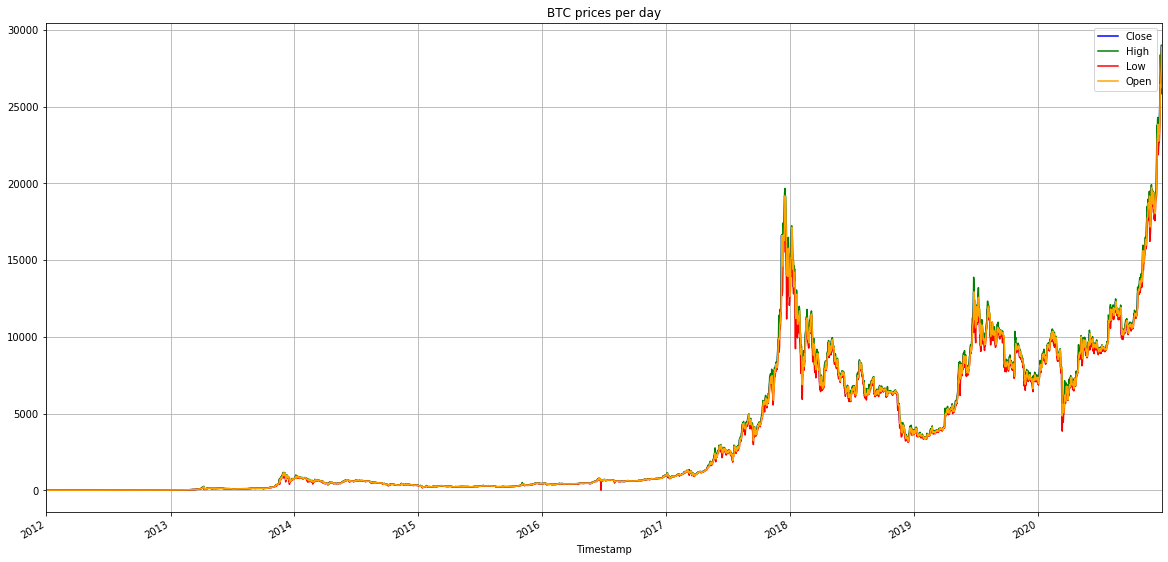

In [22]:
# Ploteamos la series.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
btc.plot(kind='line',y='Close', color='blue', ax=ax)
btc.plot(kind='line',y='High', color='green', ax=ax)
btc.plot(kind='line',y='Low', color='red', ax=ax)
btc.plot(kind='line',y='Open', color='orange', ax=ax)
plt.title('BTC prices per day')
plt.grid()
plt.show()

In [23]:
# Ploteamos la serie.
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
#btc.plot(kind='line',y='Close', color='blue', ax=ax)
#btc.plot(kind='line',y='Weighted_Price', color='gray', ax=ax)
#plt.title('Close BTC prices and VWAP per minute')
#plt.grid()
#plt.show()

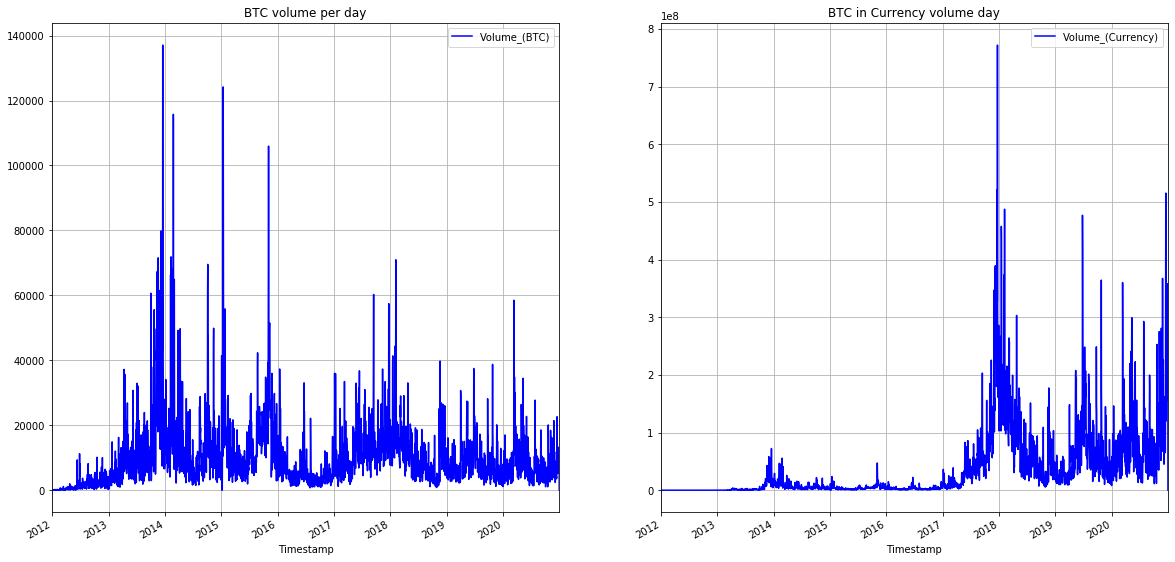

In [24]:
# Miramos el volumen operado en BTC.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
btc.plot(kind='line',y='Volume_(BTC)', color='blue', ax=ax[0])
btc.plot(kind='line',y='Volume_(Currency)', color='blue', ax=ax[1])
ax[0].set_title('BTC volume per day')
ax[1].set_title('BTC in Currency volume day')
ax[0].grid()
ax[1].grid()
plt.show()

In [25]:
# Computo el RSI para distintos dias (con el fin de sumar features explicativas)
window_lengths = [5, 10, 15, 30]
for window_length in window_lengths:
    btc['rsi_{}'.format(window_length)] = rsi(btc['Close'], window_length)

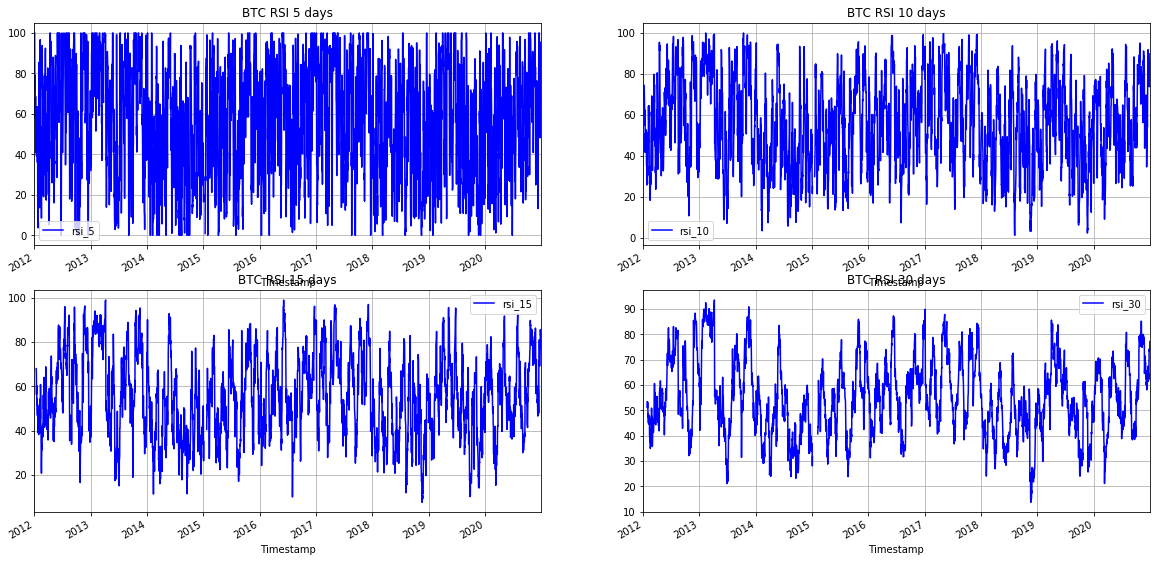

In [26]:
# Ploteamos las distintas señales de RSI
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

btc.plot(kind='line',y='rsi_5', color='blue', ax=ax[0][0])
btc.plot(kind='line',y='rsi_10', color='blue', ax=ax[0][1])
btc.plot(kind='line',y='rsi_15', color='blue', ax=ax[1][0])
btc.plot(kind='line',y='rsi_30', color='blue', ax=ax[1][1])

ax[0][0].set_title('BTC RSI 5 days')
ax[0][1].set_title('BTC RSI 10 days')
ax[1][0].set_title('BTC RSI 15 days')
ax[1][1].set_title('BTC RSI 30 days')

ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()

plt.show()

In [27]:
# Computo el logaritmo de los retornos entre muestras.
btc['log_ret'] = log_ret(btc['Close'])

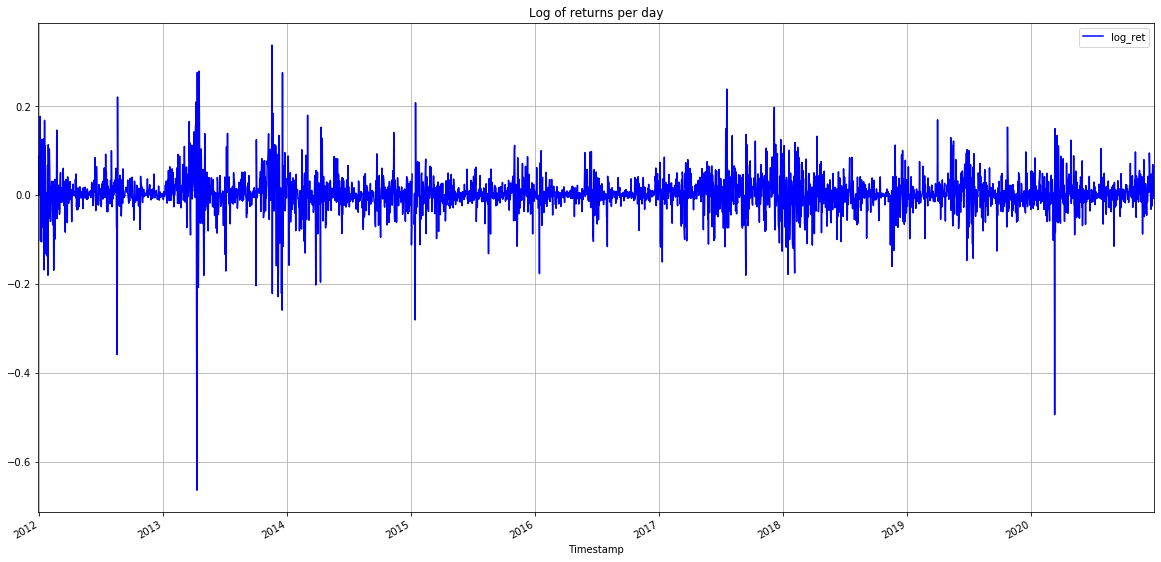

In [28]:
# Ploteamos la series.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
btc.plot(kind='line',y='log_ret', color='blue', ax=ax)
plt.title('Log of returns per day')
plt.grid()
plt.show()

In [29]:
# Computo las autocorrelaciones de 1er, 2do y 3er orden.
lags = [1, 3, 5]
window_length = 45
for lag in lags:
    btc['autocorr_{}'.format(lag)] = autocorr(btc['Close'], window_length, lag)

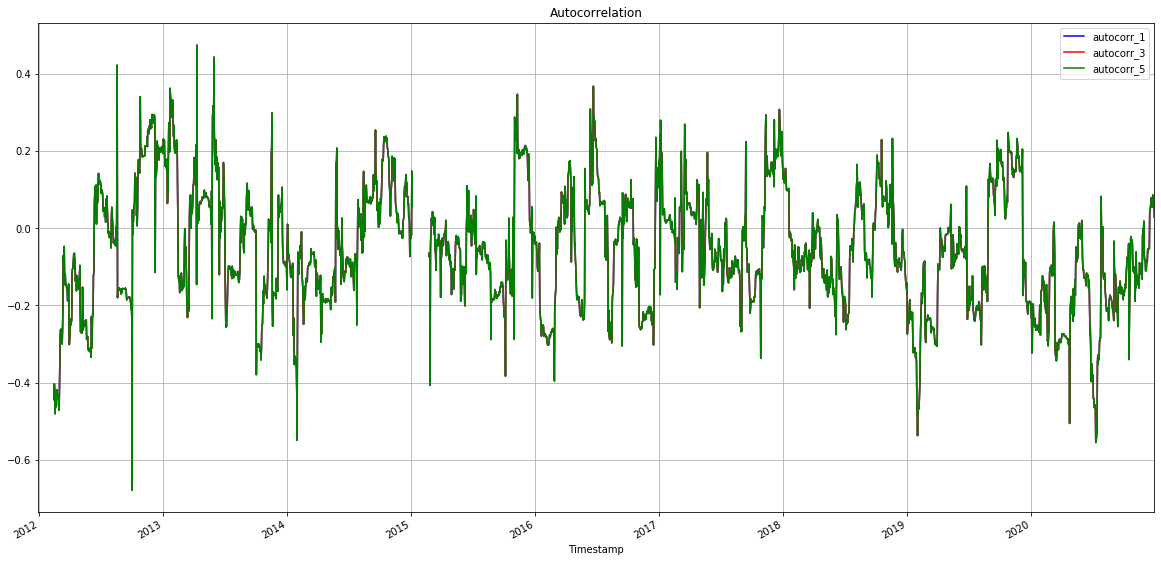

In [30]:
# Ploteamos la series.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
btc.plot(kind='line',y='autocorr_1', color='blue', ax=ax)
btc.plot(kind='line',y='autocorr_3', color='red', ax=ax)
btc.plot(kind='line',y='autocorr_5', color='green', ax=ax)
plt.title('Autocorrelation')
plt.grid()
plt.show()

In [31]:
# Computo el volatility para distintos dias (con el fin de sumar features explicativas)
window_lengths = [5, 10, 15, 30]
for window_length in window_lengths:
    btc['vol_{}'.format(window_length)] = volatility(btc['Close'], window_length)

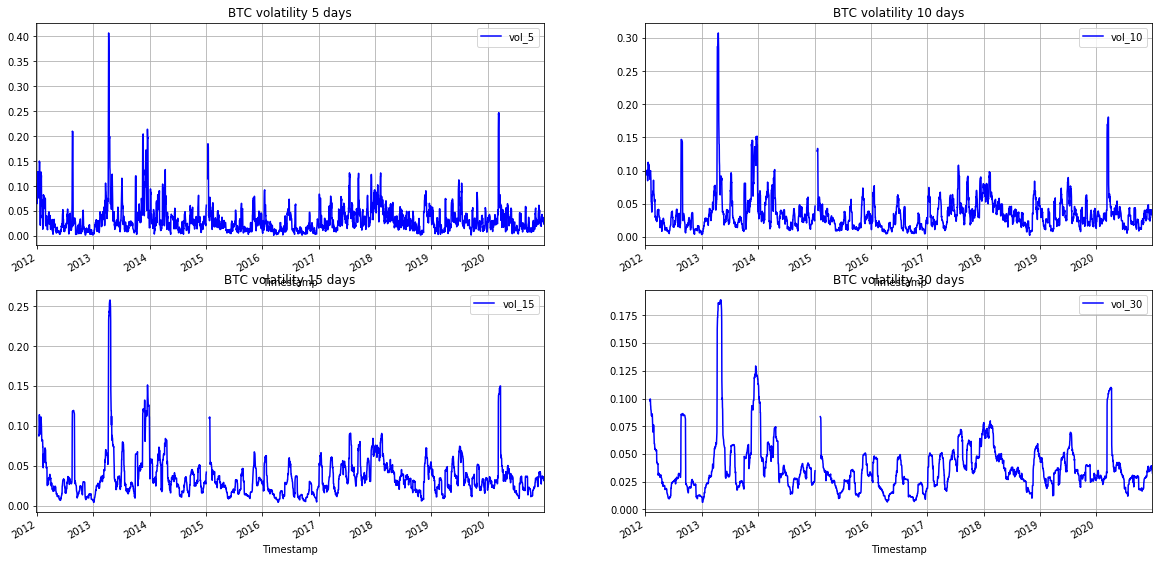

In [32]:
# Ploteamos las distintas señales de volatility
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

btc.plot(kind='line',y='vol_5', color='blue', ax=ax[0][0])
btc.plot(kind='line',y='vol_10', color='blue', ax=ax[0][1])
btc.plot(kind='line',y='vol_15', color='blue', ax=ax[1][0])
btc.plot(kind='line',y='vol_30', color='blue', ax=ax[1][1])

ax[0][0].set_title('BTC volatility 5 days')
ax[0][1].set_title('BTC volatility 10 days')
ax[1][0].set_title('BTC volatility 15 days')
ax[1][1].set_title('BTC volatility 30 days')

ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()

plt.show()

In [34]:
# Constantes para el computo de SADF
MIN_SL_SADF = 50
MAX_SL_SADF = 300
CONSTANTS_SADF = ['nt', 'ct', 'ctt']
LAGS_SADF = [1]

# Computo el logaritmo de precios.
log_p = btc['Close'].apply(lambda x: np.log(x)).dropna()

# Genero un data frame con las columnas que voy a computar.
bsadf = pd.DataFrame(index=log_p.index, columns=['bsadf_{}_{}'.format(c, l) for c in CONSTANTS_SADF for l in LAGS_SADF])

# Computo SADF
for constant in CONSTANTS_SADF:
    for lag in LAGS_SADF:
        col_name = 'bsadf_{}_{}'.format(constant, lag)
        print('Computing {}'.format(col_name))
        df = compute_bsadf(log_p.to_frame(), MIN_SL_SADF, MAX_SL_SADF, constant, lag)
        bsadf.loc[:, col_name] = df['bsadf']
# Uno los dataframes.
btc = pd.merge(btc, bsadf, how='inner', left_index=True, right_index=True)

# Elimino los dataframes auxiliares.
del bsadf
del log_p

Computing bsadf_nt_1
Computing bsadf_ct_1
Computing bsadf_ctt_1


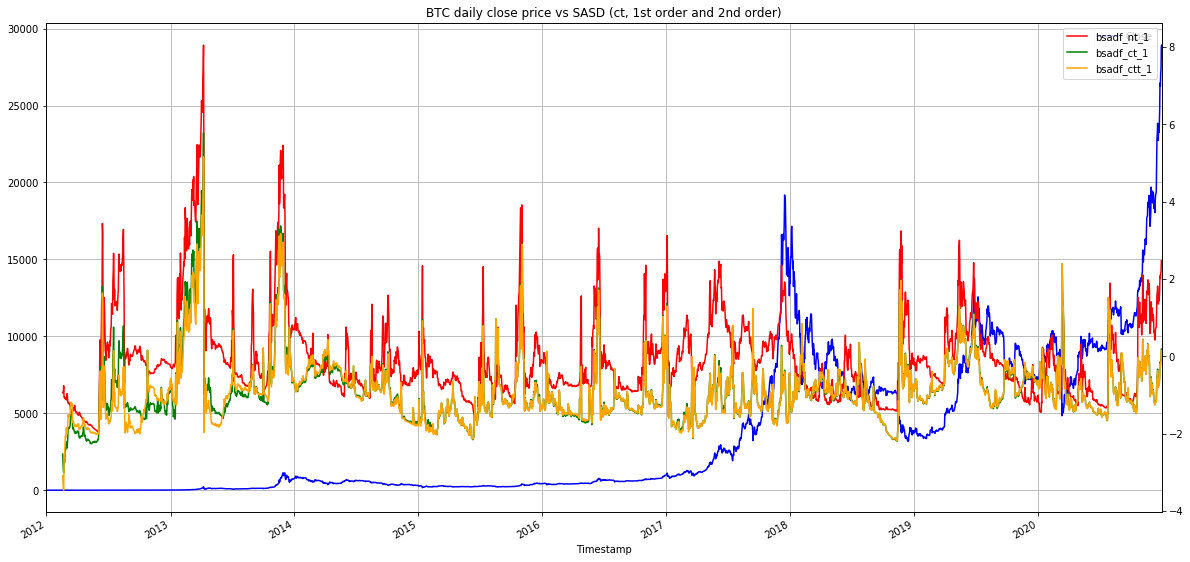

In [39]:
# Ploteamos las distintas señales de SADF
fig, ax = plt.subplots(figsize=(20,10))

btc.plot(kind='line',y='Close', color='blue', ax=ax)

ax2 = ax.twinx()

btc.plot(kind='line',y='bsadf_nt_1', color='red', ax=ax2)
btc.plot(kind='line',y='bsadf_ct_1', color='green', ax=ax2)
btc.plot(kind='line',y='bsadf_ctt_1', color='orange', ax=ax2)

ax.grid()

ax.set_title('BTC daily close price vs SASD (ct, 1st order and 2nd order)')

plt.show()

## Diferenciacion fraccionaria del dataset

        adfStat          pVal  lags    nObs  95% conf      corr
0.00  -1.586943  4.901489e-01   1.0  3284.0 -2.862421  1.000000
0.05  -1.504320  5.313735e-01   1.0  3244.0 -2.862431  0.999948
0.10  -1.688057  4.372759e-01   1.0  3223.0 -2.862437  0.999591
0.15  -1.714307  4.237564e-01   1.0  3213.0 -2.862440  0.998683
0.20  -1.802431  3.792553e-01   1.0  3212.0 -2.862440  0.997162
0.25  -2.098524  2.451086e-01   1.0  3214.0 -2.862440  0.994842
0.30  -2.443356  1.298714e-01   1.0  3219.0 -2.862438  0.991730
0.35  -2.932834  4.166092e-02   1.0  3224.0 -2.862437  0.987323
0.40  -3.528404  7.286882e-03   1.0  3230.0 -2.862435  0.981576
0.45  -4.466956  2.255165e-04   1.0  3236.0 -2.862434  0.973885
0.50  -5.274327  6.187546e-06   1.0  3241.0 -2.862432  0.962623
0.55  -6.475471  1.334547e-08   1.0  3246.0 -2.862431  0.947450
0.60  -7.886939  4.543185e-12   1.0  3251.0 -2.862429  0.927296
0.65  -9.791151  6.348463e-17   1.0  3255.0 -2.862428  0.897061
0.70 -12.140384  1.656231e-22   1.0  325

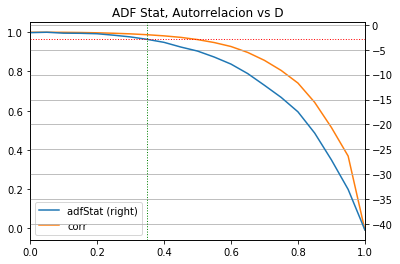

In [40]:
# Computo una lista de valores de d (el grado de diferenciación),
# y diferencio la serie de precios.
ds = np.linspace(0, 1, 21)
out = compute_multiple_ffd(btc['Close'].to_frame(), 1e-3, ds)
print(out)

# Realizamos un plot para evaluar gráficamente el valor óptimo.
out[['adfStat','corr']].plot(secondary_y='adfStat')
mean_95conf = out['95% conf'].mean()
optim_d = get_d_optim(out, conf=0.05)
plt.axhline(mean_95conf,linewidth=1,color='r',linestyle='dotted')
plt.axvline(optim_d,linewidth=1,color='g',linestyle='dotted')
plt.grid()
plt.title('ADF Stat, Autorrelacion vs D')
print('Promedio de valores críticos para el estadístico al 5%: {}'.format(mean_95conf))
print('Valor óptimo de d: {}'.format(optim_d))

In [41]:
# Differentiaties all the features.
btc['OpenFFD'] = fracDiff_FFD(btc['Open'].to_frame(), d=optim_d, thres=1e-3)
btc['HighFFD'] = fracDiff_FFD(btc['High'].to_frame(), d=optim_d, thres=1e-3)
btc['LowFFD'] = fracDiff_FFD(btc['Low'].to_frame(), d=optim_d, thres=1e-3)
btc['CloseFFD'] = fracDiff_FFD(btc['Close'].to_frame(), d=optim_d, thres=1e-3)
btc['Volume_(BTC)FFD'] = fracDiff_FFD(btc['Volume_(BTC)'].to_frame(), d=optim_d, thres=1e-3)
btc['Volume_(Currency)FFD'] = fracDiff_FFD(btc['Volume_(Currency)'].to_frame(), d=optim_d, thres=1e-3)

In [42]:
# Guardamos la diferenciacion fraccionaria para poder reutilizar el codigo luego.
FFD_DATA_PATH = '../../datasets/bitstamp_data_ffd.csv'
btc.to_csv(FFD_DATA_PATH, index_label='Timestamp', date_format='%s')

In [43]:
# Cargamos el dataset diferenciado fraccionariamente.
LOAD_FFD_DATA=False
if LOAD_FFD_DATA:
    btc = pd.read_csv(FFD_DATA_PATH, parse_dates=['Timestamp'], date_parser=unix_time_to_date, index_col='Timestamp')

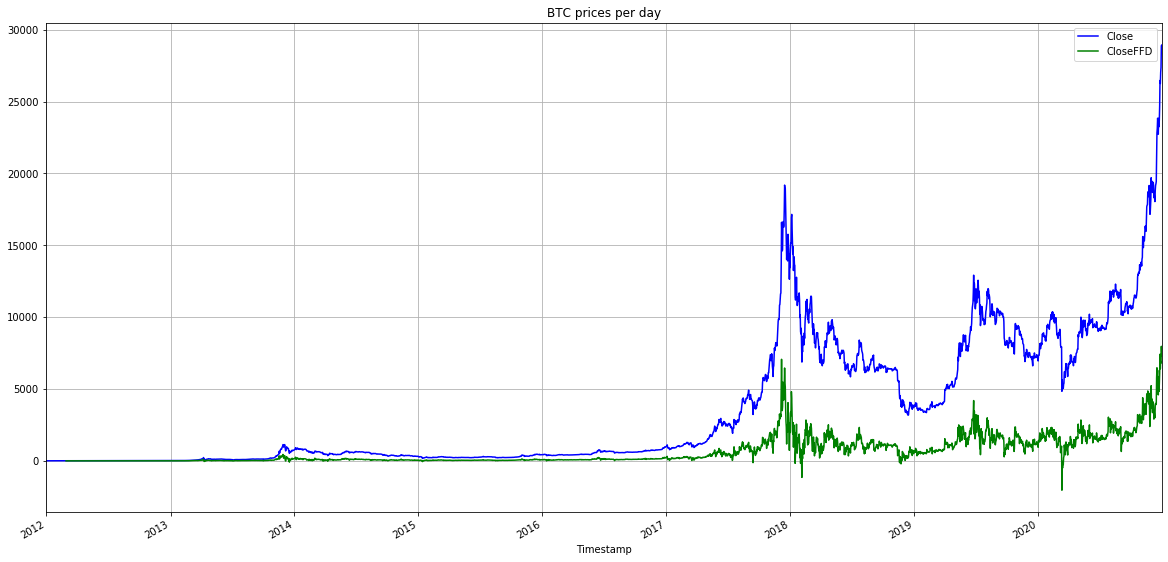

In [44]:
# Ploteamos la series.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
btc.plot(kind='line',y='Close', color='blue', ax=ax)
btc.plot(kind='line',y='CloseFFD', color='green', ax=ax)
plt.title('BTC prices per day')
plt.grid()
plt.show()

# Computamos los eventos de triple frontera

In [45]:
# Computamos los eventos de cruce de media moviles (a optimizar!)
fast_window_num_days = 2
slow_window_num_days = 5
tEvents = getEwmEvents(btc['CloseFFD'], fast_window_num_days, slow_window_num_days)
print("Eventos de cruce de señales de media movil:")
print(tEvents)

# Definimos el tiempo de la barrera vertical. Esto es algo a optimizar
# y debe ajustarse en conjunto con los valores de retorno PT y SL.
num_days = 6

# Computamos las marcas temporales de la ventana. Para cada evento
# en tEvents (inicio de la ventana), obtenemos el final de la ventana.
# Nota: a diferencia de la notebook con labelling unicamente, tEvents 
#       aquí es una serie con el side de la apuesta por lo que debemos
#       pasar el indice a getVerticalBarrier() para reutilizar la funcion.
t1 = getVerticalBarrier(tEvents.index, btc['CloseFFD'], numDays=num_days)
print("Barreras verticales para los eventos cruce de medias:")
print(t1)

Eventos de cruce de señales de media movil:
Timestamp
2012-03-04 03:00:00    1
2012-03-18 03:00:00   -1
2012-03-27 03:00:00    1
2012-04-06 03:00:00   -1
2012-04-10 03:00:00    1
                      ..
2020-11-29 03:00:00    1
2020-12-03 03:00:00   -1
2020-12-05 03:00:00    1
2020-12-06 03:00:00   -1
2020-12-12 03:00:00    1
Length: 391, dtype: int64
Barreras verticales para los eventos cruce de medias:
Timestamp
2012-03-04 03:00:00   2012-03-10 03:00:00
2012-03-18 03:00:00   2012-03-24 03:00:00
2012-03-27 03:00:00   2012-04-02 03:00:00
2012-04-06 03:00:00   2012-04-12 03:00:00
2012-04-10 03:00:00   2012-04-16 03:00:00
                              ...        
2020-11-29 03:00:00   2020-12-05 03:00:00
2020-12-03 03:00:00   2020-12-09 03:00:00
2020-12-05 03:00:00   2020-12-11 03:00:00
2020-12-06 03:00:00   2020-12-12 03:00:00
2020-12-12 03:00:00   2020-12-18 03:00:00
Name: Timestamp, Length: 391, dtype: datetime64[ns]


In [46]:
# Definimos las bandas de PT y SL.
ptSl = [0.015, 0.005]
# Computamos la volatilidad diaria, suavizada con una media
# movil pesada de 50 dias (arbitraria, también se podria aprender)
target = getDailyVol(close=btc['CloseFFD'], span0=45)
# Seleccionamos el mínimo retorno considerado.
minRet = 0.01
# Numero de CPUs para el procesamiento en paralelo. 
cpus = 4

# Generamos los eventos de la triple frontera. En esta funcion obtenemos
# un dataframe cuyo indice es cuando ocurre el evento y tiene 2 columnasÑ
# - t1: momento en el que sucede el evento.
# - trgt: retorno obtenido en ese momento.
triple_barrier_events = getEvents(btc['CloseFFD'],tEvents.index,ptSl,target,minRet,cpus,t1=t1,side=tEvents)
print("Eventos de triple frontera y retorno obtenido: ")
print(triple_barrier_events)

# Obtenemos los labels! Los labels nos dan la siguiente informacion:
# - Indice: momento en el que ocurre el evento segun nuestra estrategia.
# - Columna ret: el retorno que vamos a obtener.
# - Columna bin: lo que sucede con la señal de la apuesta:
#   - 1: se toma la apuesta.
#   - 0: no se toma la apuesta.
labels = getBins(triple_barrier_events, btc['CloseFFD'])
print("Labels para triple frontera: ")
print(labels)

# Una pequeña tabla de contención que nos indica como se distribuyen
# los labels.
print(labels['bin'].value_counts())

Eventos de triple frontera y retorno obtenido: 
                                     t1      trgt  side
Timestamp                                              
2012-03-04 03:00:00 2012-03-05 03:00:00  0.571779     1
2012-03-18 03:00:00 2012-03-19 03:00:00  0.292339    -1
2012-03-27 03:00:00 2012-03-28 03:00:00  0.348600     1
2012-04-06 03:00:00 2012-04-07 03:00:00  0.279288    -1
2012-04-10 03:00:00 2012-04-11 03:00:00  0.264182     1
...                                 ...       ...   ...
2020-11-29 03:00:00 2020-11-30 03:00:00  0.239540     1
2020-12-03 03:00:00 2020-12-04 03:00:00  0.232830    -1
2020-12-05 03:00:00 2020-12-06 03:00:00  0.226962     1
2020-12-06 03:00:00 2020-12-07 03:00:00  0.223097    -1
2020-12-12 03:00:00 2020-12-13 03:00:00  0.222308     1

[391 rows x 3 columns]
Labels para triple frontera: 
                          ret  bin
Timestamp                         
2012-03-04 03:00:00 -0.168993  0.0
2012-03-18 03:00:00 -0.232617  0.0
2012-03-27 03:00:00 -0.143410 

2021-02-07 16:27:44.993269 100.0% applyPtSlOnT1 done after 0.0 minutes. Remaining 0.0 minutes.


# Computo de uniqueness

In [47]:
# Obtengo los coeficientes de concurrencia para cada evento.
numCoEvents = mpPandasObj(mpNumCoEvents,('molecule',triple_barrier_events.index),cpus,
                          closeIdx=btc.index,t1=triple_barrier_events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(btc['CloseFFD'].index).fillna(0)

# Genero un data frame que contenga en una columna los pesos por concurrencia
# y en otra los pesos por concurrencia + retornos.
out=pd.DataFrame()
out['tW'] = mpPandasObj(mpSampleTW,('molecule',triple_barrier_events.index),cpus,
                        t1=triple_barrier_events['t1'],numCoEvents=numCoEvents)
out['w'] = mpPandasObj(mpSampleW,('molecule',triple_barrier_events.index),cpus,
                       t1=triple_barrier_events['t1'],numCoEvents=numCoEvents,close=btc['CloseFFD'])
out['w'] *= out.shape[0]/out['w'].sum()
averageUniqueness = out.mean()[0]
print("Dataframe de concurrencia de eventos en ventanas de triple frontera: ")
print(out)
print("Average uniqueness: ")
print(averageUniqueness)


# Genero un data frame entre las concurrencias y los retornos diarios.
coEvents_std = (pd.DataFrame().assign(numCoEvents = numCoEvents, std = target))
print("Dataframe de concurrencia de eventos en ventanas de triple frontera y volatilidad")
print(coEvents_std)
print(coEvents_std.loc[:, "numCoEvents"].value_counts())

2021-02-07 16:27:45.343675 100.0% mpNumCoEvents done after 0.0 minutes. Remaining 0.0 minutes.
2021-02-07 16:27:45.572182 100.0% mpSampleTW done after 0.0 minutes. Remaining 0.0 minutes.
/home/agustin/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/agustin/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/agustin/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/agustin/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
2021-02-07 16:27:45.938108 100.0% mpSampleW done after 0.0 minutes. Remaining 0.0 minutes

Dataframe de concurrencia de eventos en ventanas de triple frontera: 
                       tW         w
2012-03-04 03:00:00  1.00  0.370623
2012-03-18 03:00:00  1.00  1.854655
2012-03-27 03:00:00  1.00  0.477389
2012-04-06 03:00:00  1.00  0.806677
2012-04-10 03:00:00  1.00  0.486642
...                   ...       ...
2020-11-29 03:00:00  1.00  0.294908
2020-12-03 03:00:00  1.00  0.326672
2020-12-05 03:00:00  0.75  0.132554
2020-12-06 03:00:00  0.75  1.530900
2020-12-12 03:00:00  1.00  0.041725

[391 rows x 2 columns]
Average uniqueness: 
0.916240409207161
Dataframe de concurrencia de eventos en ventanas de triple frontera y volatilidad
                     numCoEvents       std
Timestamp                                 
2011-12-30 03:00:00          0.0       NaN
2011-12-31 03:00:00          0.0       NaN
2012-01-01 03:00:00          0.0       NaN
2012-01-02 03:00:00          0.0       NaN
2012-01-03 03:00:00          0.0       NaN
...                          ...       ...
2020-12-2

# Modelo de ML

## Preparo la informacion

In [48]:
# Preparamos la informacion para introducirla en un modelo de ML.
features = ['trgt', 'side', 'OpenFFD', 'HighFFD', 'LowFFD','CloseFFD','Volume_(BTC)FFD', 'Volume_(Currency)FFD',
            'rsi_5', 'rsi_10', 'rsi_15', 'rsi_30', 'log_ret', 'autocorr_1', 'autocorr_3', 'autocorr_5',
            'vol_5', 'vol_10', 'vol_15', 'vol_30',]
btc_features = ['OpenFFD', 'HighFFD', 'LowFFD','CloseFFD','Volume_(BTC)FFD', 'Volume_(Currency)FFD',
                'rsi_5', 'rsi_10', 'rsi_15', 'rsi_30', 'log_ret', 'autocorr_1', 'autocorr_3', 'autocorr_5',
                'vol_5', 'vol_10', 'vol_15', 'vol_30',]
Xy = (pd.merge_asof(triple_barrier_events,
                    btc.loc[triple_barrier_events.index, btc_features], 
                    left_index=True,
                    right_index=True, 
                    direction='forward').dropna())
Xy = (pd.merge_asof(Xy,
                    labels[['bin']], 
                    left_index=True,
                    right_index=True, 
                    direction='forward').dropna())
sample_weights_df = out.loc[Xy.index, ['w']]
tt1 = t1.loc[Xy.index]
print(Xy)
print(tt1)

X = Xy.copy()[features].values
y = Xy.copy().bin.values
sample_weights = sample_weights_df.copy().w.values
# Realizamos un train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
sample_weights_train, sample_weights_test = sample_weights[:X_train.shape[0]], sample_weights[X_train.shape[0]:]

                                     t1      trgt  side      OpenFFD  \
Timestamp                                                              
2012-03-04 03:00:00 2012-03-05 03:00:00  0.571779     1     0.706970   
2012-03-18 03:00:00 2012-03-19 03:00:00  0.292339    -1     0.861738   
2012-03-27 03:00:00 2012-03-28 03:00:00  0.348600     1     0.844657   
2012-04-06 03:00:00 2012-04-07 03:00:00  0.279288    -1     0.868219   
2012-04-10 03:00:00 2012-04-11 03:00:00  0.264182     1     0.879635   
...                                 ...       ...   ...          ...   
2020-11-29 03:00:00 2020-11-30 03:00:00  0.239540     1  3927.882725   
2020-12-03 03:00:00 2020-12-04 03:00:00  0.232830    -1  4289.322050   
2020-12-05 03:00:00 2020-12-06 03:00:00  0.226962     1  4038.544332   
2020-12-06 03:00:00 2020-12-07 03:00:00  0.223097    -1  4108.407982   
2020-12-12 03:00:00 2020-12-13 03:00:00  0.222308     1  3875.927211   

                         HighFFD       LowFFD     CloseFFD  Vol

## Modelo base bagging

In [49]:
# Usamos bagging ahora con el averageUniqueness
# Hiperpametros
n_estimator = 1000    # Numero de arboles.
max_samples = averageUniqueness     # Porcion del data set a samplear para cada arbol.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
base_model = BaggingClassifier(max_samples=max_samples, n_estimators=n_estimator,
                               n_jobs=n_jobs, random_state=123, oob_score=True)
base_model.fit(X_train, y_train, sample_weights_train)

print("Out of bag accuracy: ")
print(base_model.oob_score_)

# Predecimos con el test set y contrastamos.
y_pred_base_model_prob = base_model.predict_proba(X_test)[:, 1]
y_pred_base_model = base_model.predict(X_test)

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_base_model, tpr_base_model, _ = roc_curve(y_test, y_pred_base_model_prob)
print(classification_report(y_test, y_pred_base_model))

Out of bag accuracy: 
0.7083333333333334
              precision    recall  f1-score   support

         0.0       0.71      0.93      0.80       137
         1.0       0.23      0.05      0.09        55

    accuracy                           0.68       192
   macro avg       0.47      0.49      0.45       192
weighted avg       0.57      0.68      0.60       192



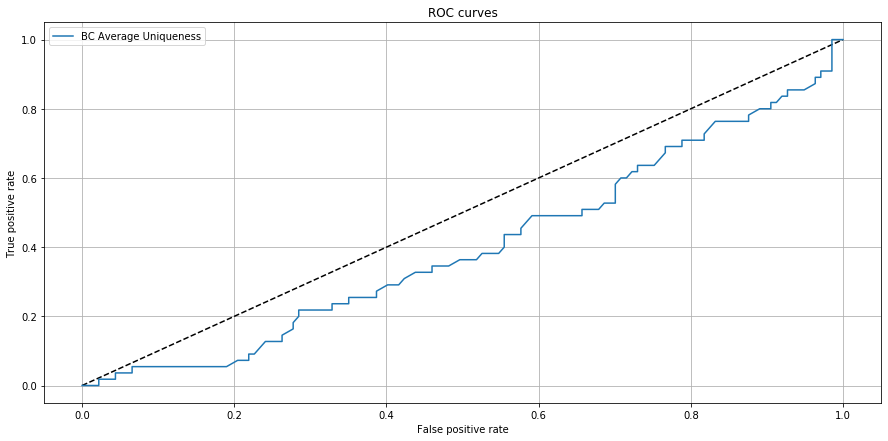

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_base_model, tpr_base_model, label='BC Average Uniqueness')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves')
plt.legend(loc='best')
plt.grid()
plt.show()

## Modelo base random forest

In [51]:
# Hiperpametros
n_estimator = 1000     # Numero de arboles.
max_samples = averageUniqueness     # Porcion del data set a samplear para cada arbol.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
max_depth = 2         # Numero de niveles que va a tener cada arbol. Al elegir un split binario
                      # permitimos que el entrenamiento sea mas lento.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# Para mas argumentos, revisar https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                            criterion=criterion, n_jobs=n_jobs, random_state=123,
                            oob_score=True)
rf.fit(X_train, y_train, sample_weights_train)

print("Out of bag accuracy: ")
print(rf.oob_score_)

# Predecimos con el test set y contrastamos.
y_pred_rf_prob = rf.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict(X_test)

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
print(classification_report(y_test, y_pred_rf))

Out of bag accuracy: 
0.7291666666666666
              precision    recall  f1-score   support

         0.0       0.71      0.91      0.80       137
         1.0       0.20      0.05      0.09        55

    accuracy                           0.67       192
   macro avg       0.45      0.48      0.44       192
weighted avg       0.56      0.67      0.59       192



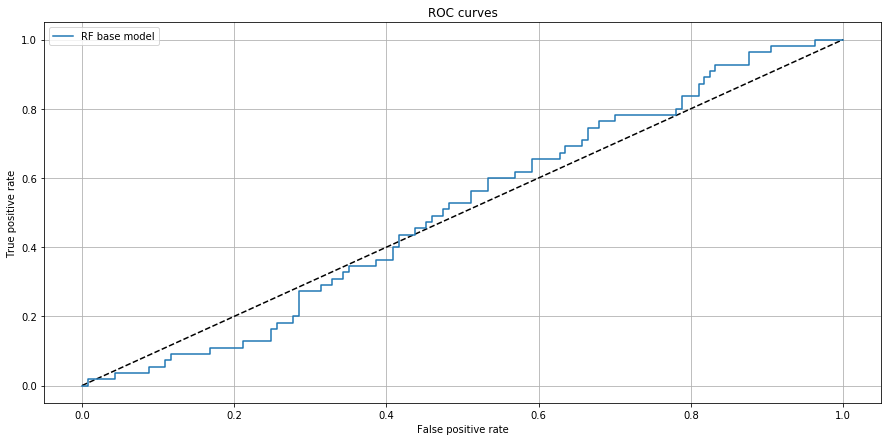

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF base model')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves')
plt.legend(loc='best')
plt.grid()
plt.show()

## Validacion cruzada con embargo y purga

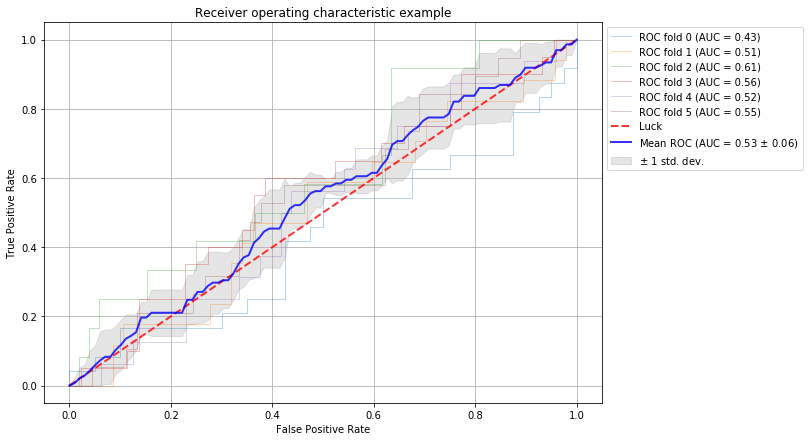

In [53]:
# Busquemos un mejor modelo, entrenado con CV + Embargo.
PCT_EMBARGO = 0.01 # En porcentaje
CV_SPLITS = 6

# Hiperpametros
n_estimator = 1000    # Numero de arboles.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
max_depth = 2         # Numero de niveles que va a tener cada arbol. Al elegir un split binario
                      # permitimos que el entrenamiento sea mas lento.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# Para mas argumentos, revisar https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

rf_pkf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                                criterion=criterion, n_jobs=n_jobs, random_state=123)

pkf = PurgedKFold(n_splits=CV_SPLITS, t1=tt1, pctEmbargo=PCT_EMBARGO)

crossValPlot2(pkf,rf_pkf,Xy.copy()[features], Xy.copy().bin, sample_weights_df)

## Optimizacion de hiperparámetros

In [54]:
# Busquemos un mejor modelo, entrenado con CV + Embargo.
PCT_EMBARGO = 0.01 # En porcentaje
CV_SPLITS = 6
N_ITER_RANDOMIZED_SEARCH=10

param_grid = {
    'n_estimators': [100, 200, 500, 1000, 1500],
    'criterion': ['entropy'],
    'max_depth': [2],
    'min_samples_split': [2, 5, 10, 20, 50],
    'max_features': ['auto'],
    'oob_score': [True],
    'random_state': [123],
    'n_jobs':[-1],
    
}

# TODO(agalbachicar): usar un pipeline propio que tome average uniqueness.
randomized_search_cv = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                          param_distributions=param_grid,
                                          scoring='f1',
                                          cv=PurgedKFold(n_splits=CV_SPLITS, t1=tt1, pctEmbargo=PCT_EMBARGO),
                                          n_jobs=-1,
                                          n_iter=N_ITER_RANDOMIZED_SEARCH,
                                          return_train_score=True)
search_rcv = randomized_search_cv.fit(Xy.copy()[features], Xy.copy().bin, sample_weight=sample_weights_df.w.values)

In [55]:
print('Ranking: ')
print(randomized_search_cv.cv_results_["rank_test_score"])

print('Best score: ')
print(randomized_search_cv.best_score_)

print('Best parameters: ')
print(randomized_search_cv.best_params_)

Ranking: 
[ 1  3  6  4  2 10  8  5  9  7]
Best score: 
0.22823957646168633
Best parameters: 
{'random_state': 123, 'oob_score': True, 'n_jobs': -1, 'n_estimators': 1000, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 2, 'criterion': 'entropy'}


In [56]:
# Predecimos con el test set y contrastamos.
y_pred_rsrf_prob = randomized_search_cv.predict_proba(X_test)[:, 1]
y_pred_rsrf = randomized_search_cv.predict(X_test)

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_rsrf, tpr_rsrf, _ = roc_curve(y_test, y_pred_rsrf_prob)
print(classification_report(y_test, y_pred_rsrf))

              precision    recall  f1-score   support

         0.0       0.79      0.94      0.86       137
         1.0       0.72      0.38      0.50        55

    accuracy                           0.78       192
   macro avg       0.76      0.66      0.68       192
weighted avg       0.77      0.78      0.76       192



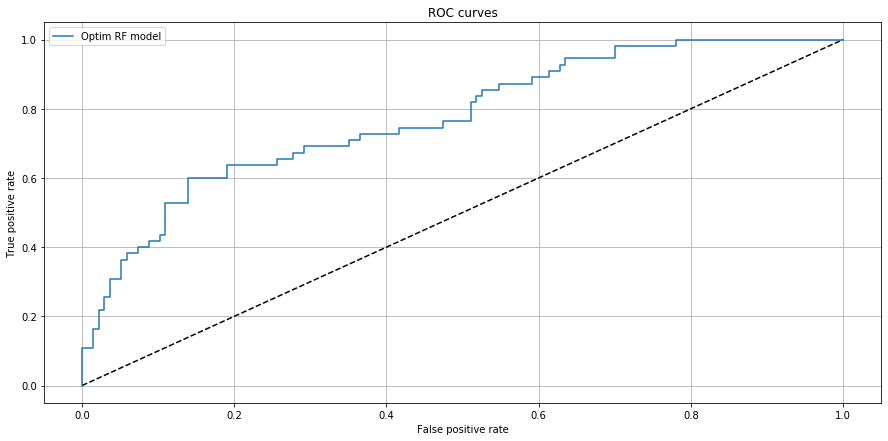

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rsrf, tpr_rsrf, label='Optim RF model')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves')
plt.legend(loc='best')
plt.grid()
plt.show()

## Feature importance

In [58]:
cont = pd.DataFrame()
cont['bin'] = Xy.copy().bin
cont['w'] = sample_weights_df['w']
cont['t1'] = tt1

In [59]:
imp_mda, oob_mda, oos_mda = featImportance(Xy.copy()[features], cont,
                                           n_estimators=randomized_search_cv.best_params_['n_estimators'],
                                           cv=CV_SPLITS,
                                           max_samples=averageUniqueness,
                                           numThreads=n_jobs,
                                           pctEmbargo=PCT_EMBARGO,
                                           scoring='neg_log_loss',
                                           method='MDA',
                                           criterion=criterion,
                                           max_depth=max_depth)

In [60]:
imp_mdi, oob_mdi, oos_mdi = featImportance(Xy.copy()[features], cont,
                                           n_estimators=randomized_search_cv.best_params_['n_estimators'],
                                           cv=CV_SPLITS,
                                           max_samples=averageUniqueness,
                                           numThreads=n_jobs,
                                           pctEmbargo=PCT_EMBARGO,
                                           scoring='neg_log_loss',
                                           method='MDI',
                                           criterion=criterion,
                                           max_depth=max_depth)

In [61]:
imp_sfi, oob_sfi, oos_sfi = featImportance(Xy.copy()[features], cont,
                                           n_estimators=randomized_search_cv.best_params_['n_estimators'],
                                           cv=CV_SPLITS,
                                           max_samples=averageUniqueness,
                                           numThreads=n_jobs,
                                           pctEmbargo=PCT_EMBARGO,
                                           scoring='neg_log_loss',
                                           method='SFI',
                                           criterion=criterion,
                                           max_depth=max_depth)

2021-02-07 16:35:59.007399 100.0% featImpSFI done after 4.09 minutes. Remaining 0.0 minutes..


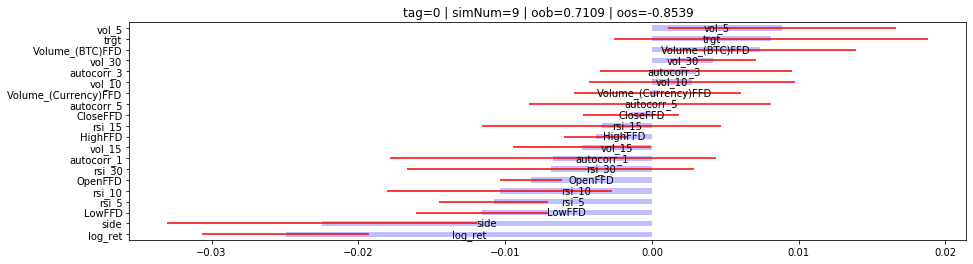

In [62]:
plotFeatImp(None, imp_mda, oob_mda, oos_mda, 'MDA')

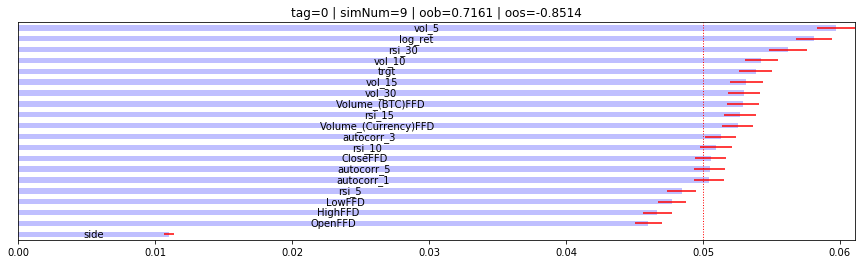

In [78]:
plotFeatImp(None, imp_mdi, oob_mdi, oos_mdi, 'MDI')

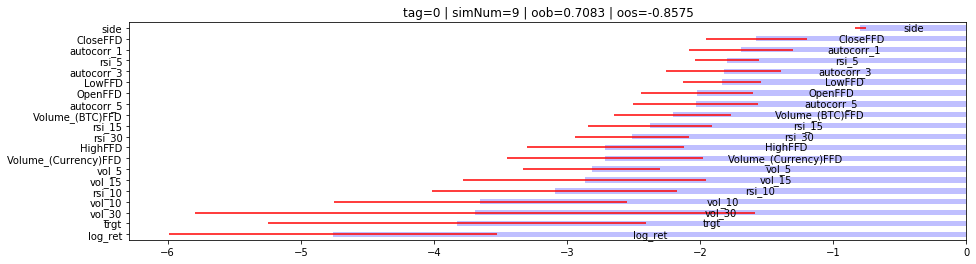

In [79]:
plotFeatImp(None, imp_sfi, oob_sfi, oos_sfi, 'SFI')

## Metricas financieras

In [80]:
Xx = Xy.copy()[features]
yy = Xy.copy().bin
X_trainn, X_testt, y_trainn, y_testt = train_test_split(Xx, yy, test_size=0.5, shuffle=False)

/home/agustin/anaconda3/lib/python3.7/site-packages/empyrical/stats.py:1494: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()


Start date,2016-11-23
End date,2020-12-12
Total months,9
,Backtest
Annual return,-100.0%
Cumulative returns,-100.0%
Annual volatility,542.5%
Sharpe ratio,-4.79
Calmar ratio,-0.99
Stability,NaN
Max drawdown,-100.9%


/home/agustin/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,100.92,2016-11-30,2018-01-29,NaT,NaN
1,0.00,2016-11-23,2016-11-23,2016-11-23,1
2,0.00,2016-11-23,2016-11-23,2016-11-23,1
3,0.00,2016-11-23,2016-11-23,2016-11-23,1
4,0.00,2016-11-23,2016-11-23,2016-11-23,1


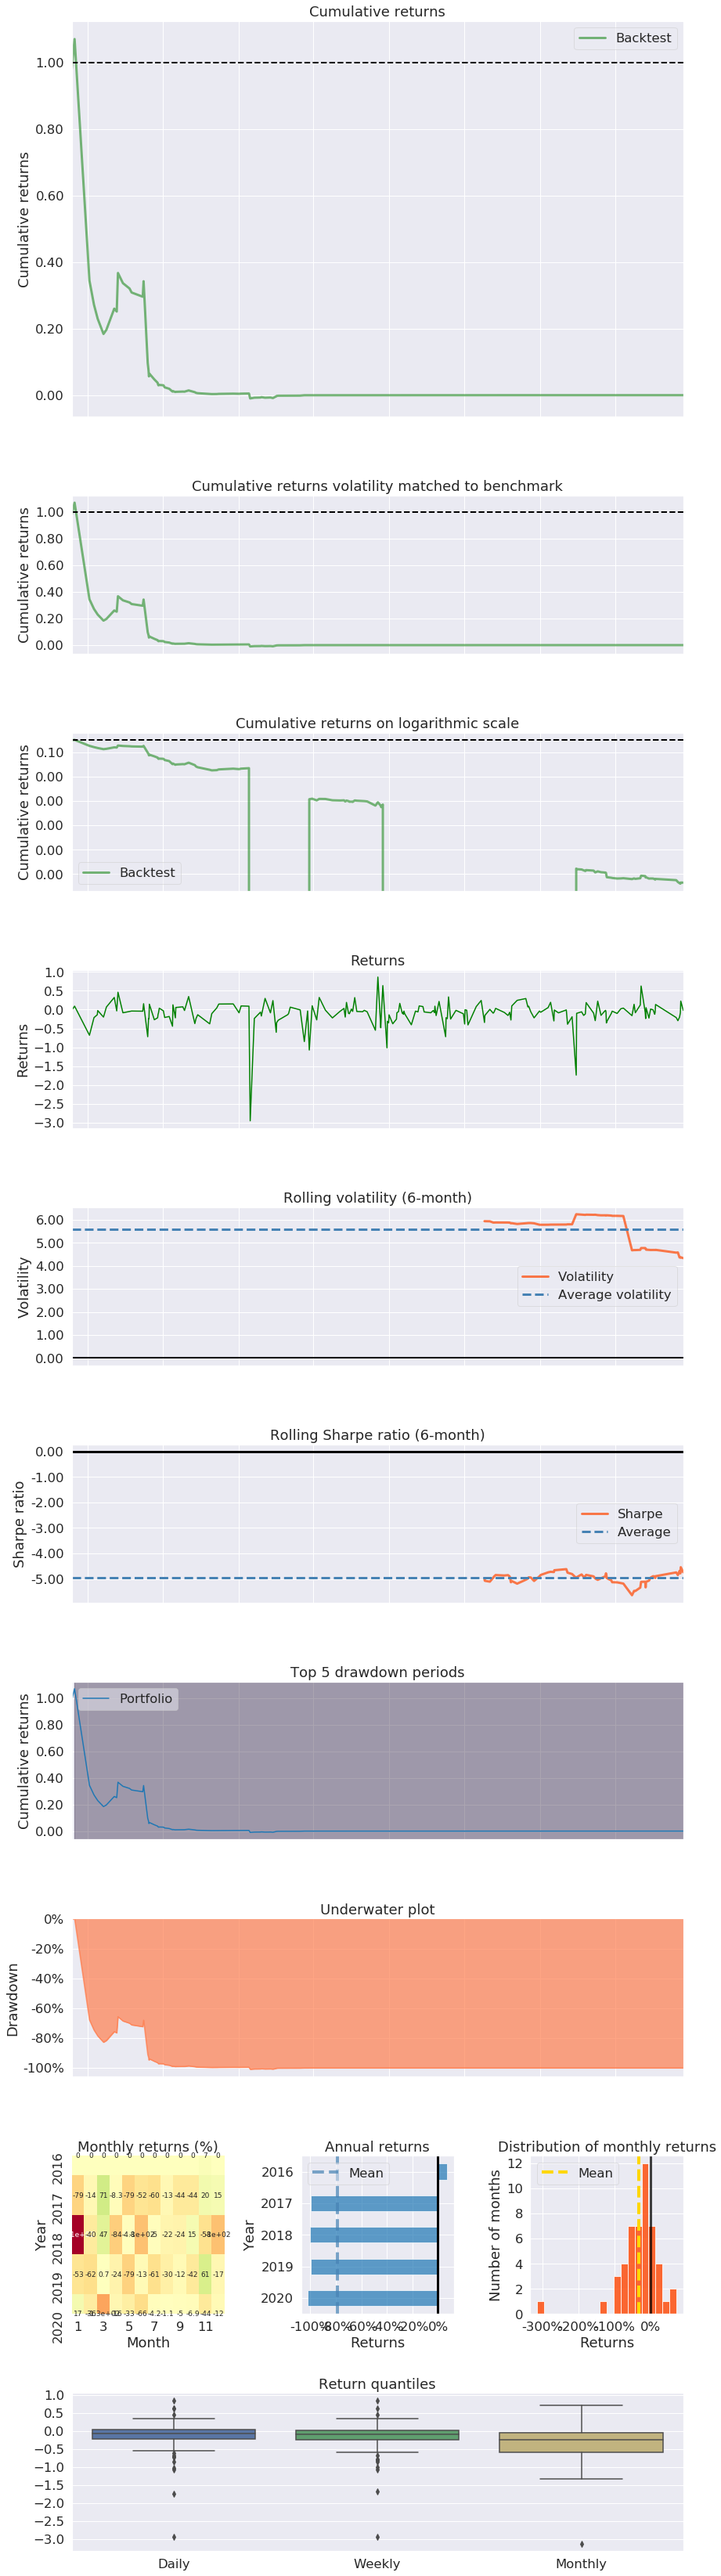

In [81]:
test_dates = X_testt.index
pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)

Start date,2016-11-23
End date,2020-12-12
Total months,9
,Backtest
Annual return,-91.6%
Cumulative returns,-84.9%
Annual volatility,225.6%
Sharpe ratio,0.39
Calmar ratio,-0.99
Stability,0.01
Max drawdown,-92.9%


/home/agustin/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,92.85,2016-11-30,2017-07-25,NaT,NaN
1,0.00,2016-11-23,2016-11-23,2016-11-23,1
2,0.00,2016-11-23,2016-11-23,2016-11-23,1
3,0.00,2016-11-23,2016-11-23,2016-11-23,1
4,0.00,2016-11-23,2016-11-23,2016-11-23,1


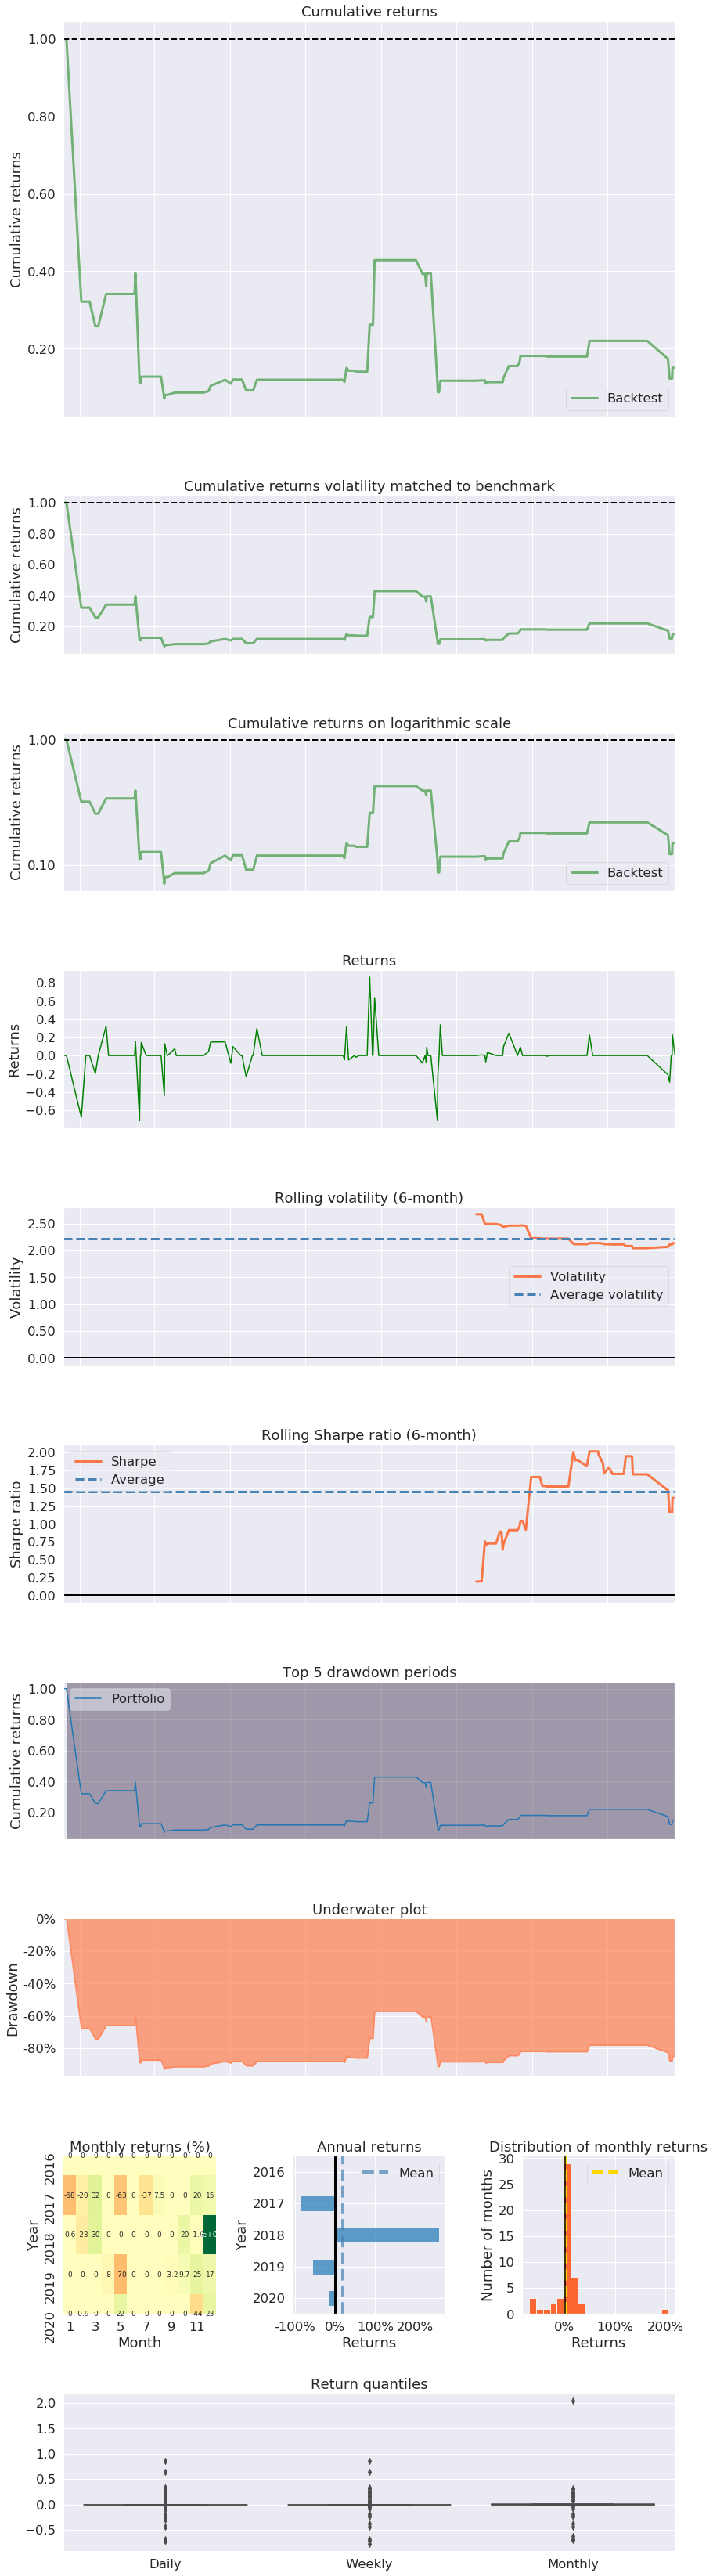

In [82]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred_rsrf
pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None)

# Nuevo modelo con SADF

## Preparo la informacion

In [86]:
# Preparamos la informacion para introducirla en un modelo de ML.
features = ['trgt', 'side', 'OpenFFD', 'HighFFD', 'LowFFD','CloseFFD','Volume_(BTC)FFD', 'Volume_(Currency)FFD',
            'rsi_5', 'rsi_10', 'rsi_15', 'rsi_30', 'log_ret', 'autocorr_1', 'autocorr_3', 'autocorr_5',
            'vol_5', 'vol_10', 'vol_15', 'vol_30', 'bsadf_nt_1', 'bsadf_ct_1', 'bsadf_ctt_1',]
btc_features = ['OpenFFD', 'HighFFD', 'LowFFD','CloseFFD','Volume_(BTC)FFD', 'Volume_(Currency)FFD',
                'rsi_5', 'rsi_10', 'rsi_15', 'rsi_30', 'log_ret', 'autocorr_1', 'autocorr_3', 'autocorr_5',
                'vol_5', 'vol_10', 'vol_15', 'vol_30', 'bsadf_nt_1', 'bsadf_ct_1', 'bsadf_ctt_1',]
Xy = (pd.merge_asof(triple_barrier_events,
                    btc.loc[triple_barrier_events.index, btc_features], 
                    left_index=True,
                    right_index=True, 
                    direction='forward').dropna())
Xy = (pd.merge_asof(Xy,
                    labels[['bin']], 
                    left_index=True,
                    right_index=True, 
                    direction='forward').dropna())
sample_weights_df = out.loc[Xy.index, ['w']]
tt1 = t1.loc[Xy.index]
print(Xy)
print(tt1)

X = Xy.copy()[features].values
y = Xy.copy().bin.values
sample_weights = sample_weights_df.copy().w.values
# Realizamos un train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
sample_weights_train, sample_weights_test = sample_weights[:X_train.shape[0]], sample_weights[X_train.shape[0]:]

                                     t1      trgt  side      OpenFFD  \
Timestamp                                                              
2012-03-04 03:00:00 2012-03-05 03:00:00  0.571779     1     0.706970   
2012-03-18 03:00:00 2012-03-19 03:00:00  0.292339    -1     0.861738   
2012-03-27 03:00:00 2012-03-28 03:00:00  0.348600     1     0.844657   
2012-04-06 03:00:00 2012-04-07 03:00:00  0.279288    -1     0.868219   
2012-04-10 03:00:00 2012-04-11 03:00:00  0.264182     1     0.879635   
...                                 ...       ...   ...          ...   
2020-11-29 03:00:00 2020-11-30 03:00:00  0.239540     1  3927.882725   
2020-12-03 03:00:00 2020-12-04 03:00:00  0.232830    -1  4289.322050   
2020-12-05 03:00:00 2020-12-06 03:00:00  0.226962     1  4038.544332   
2020-12-06 03:00:00 2020-12-07 03:00:00  0.223097    -1  4108.407982   
2020-12-12 03:00:00 2020-12-13 03:00:00  0.222308     1  3875.927211   

                         HighFFD       LowFFD     CloseFFD  Vol

## Validacion cruzada con embargo y purga

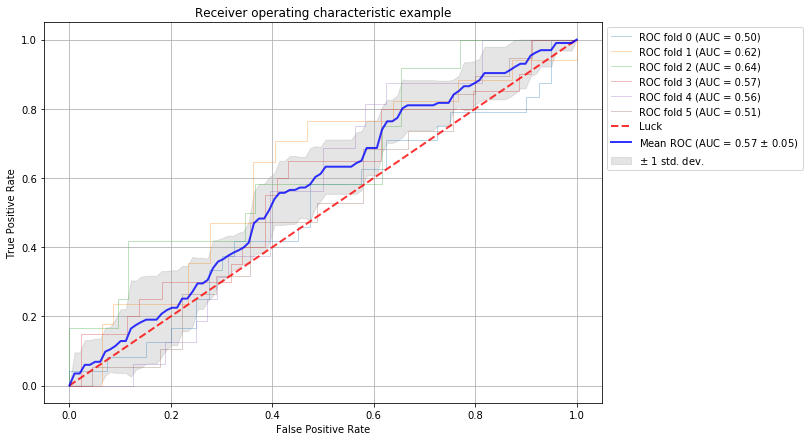

In [87]:
# Busquemos un mejor modelo, entrenado con CV + Embargo.
PCT_EMBARGO = 0.01 # En porcentaje
CV_SPLITS = 6

# Hiperpametros
n_estimator = 1000    # Numero de arboles.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
max_depth = 2         # Numero de niveles que va a tener cada arbol. Al elegir un split binario
                      # permitimos que el entrenamiento sea mas lento.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# Para mas argumentos, revisar https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

rf_pkf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                                criterion=criterion, n_jobs=n_jobs, random_state=123)

pkf = PurgedKFold(n_splits=CV_SPLITS, t1=tt1, pctEmbargo=PCT_EMBARGO)

crossValPlot2(pkf,rf_pkf,Xy.copy()[features], Xy.copy().bin, sample_weights_df)

## Optimizacion de hiperparametros

In [88]:
# Busquemos un mejor modelo, entrenado con CV + Embargo.
PCT_EMBARGO = 0.01 # En porcentaje
CV_SPLITS = 6
N_ITER_RANDOMIZED_SEARCH=10

param_grid = {
    'n_estimators': [100, 200, 500, 1000, 1500],
    'criterion': ['entropy'],
    'max_depth': [2],
    'min_samples_split': [2, 5, 10, 20, 50],
    'max_features': ['auto'],
    'oob_score': [True],
    'random_state': [123],
    'n_jobs':[-1],
    
}

# TODO(agalbachicar): usar un pipeline propio que tome average uniqueness.
randomized_search_cv = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                          param_distributions=param_grid,
                                          scoring='f1',
                                          cv=PurgedKFold(n_splits=CV_SPLITS, t1=tt1, pctEmbargo=PCT_EMBARGO),
                                          n_jobs=-1,
                                          n_iter=N_ITER_RANDOMIZED_SEARCH,
                                          return_train_score=True)
search_rcv = randomized_search_cv.fit(Xy.copy()[features], Xy.copy().bin, sample_weight=sample_weights_df.w.values)

In [89]:
print('Ranking: ')
print(randomized_search_cv.cv_results_["rank_test_score"])

print('Best score: ')
print(randomized_search_cv.best_score_)

print('Best parameters: ')
print(randomized_search_cv.best_params_)

Ranking: 
[ 6  5  4  2 10  7  9  1  8  3]
Best score: 
0.2554419876697724
Best parameters: 
{'random_state': 123, 'oob_score': True, 'n_jobs': -1, 'n_estimators': 1500, 'min_samples_split': 50, 'max_features': 'auto', 'max_depth': 2, 'criterion': 'entropy'}


In [90]:
# Predecimos con el test set y contrastamos.
y_pred_rsrf_prob = randomized_search_cv.predict_proba(X_test)[:, 1]
y_pred_rsrf = randomized_search_cv.predict(X_test)

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_rsrf, tpr_rsrf, _ = roc_curve(y_test, y_pred_rsrf_prob)
print(classification_report(y_test, y_pred_rsrf))

              precision    recall  f1-score   support

         0.0       0.77      0.76      0.76       137
         1.0       0.42      0.44      0.43        55

    accuracy                           0.67       192
   macro avg       0.60      0.60      0.60       192
weighted avg       0.67      0.67      0.67       192



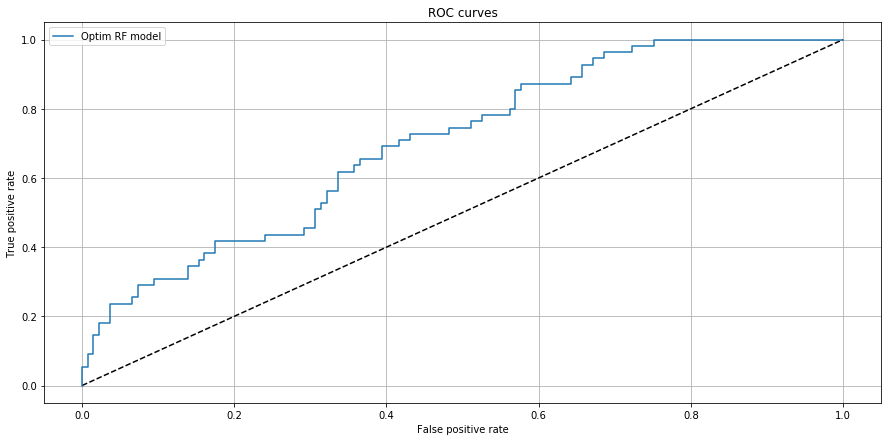

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rsrf, tpr_rsrf, label='Optim RF model')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves')
plt.legend(loc='best')
plt.grid()
plt.show()

## Feature importance

In [92]:
cont = pd.DataFrame()
cont['bin'] = Xy.copy().bin
cont['w'] = sample_weights_df['w']
cont['t1'] = tt1

In [93]:
imp_mda, oob_mda, oos_mda = featImportance(Xy.copy()[features], cont,
                                           n_estimators=randomized_search_cv.best_params_['n_estimators'],
                                           cv=CV_SPLITS,
                                           max_samples=averageUniqueness,
                                           numThreads=n_jobs,
                                           pctEmbargo=PCT_EMBARGO,
                                           scoring='neg_log_loss',
                                           method='MDA',
                                           criterion=criterion,
                                           max_depth=max_depth)

In [94]:
imp_mdi, oob_mdi, oos_mdi = featImportance(Xy.copy()[features], cont,
                                           n_estimators=randomized_search_cv.best_params_['n_estimators'],
                                           cv=CV_SPLITS,
                                           max_samples=averageUniqueness,
                                           numThreads=n_jobs,
                                           pctEmbargo=PCT_EMBARGO,
                                           scoring='neg_log_loss',
                                           method='MDI',
                                           criterion=criterion,
                                           max_depth=max_depth)

In [95]:
imp_sfi, oob_sfi, oos_sfi = featImportance(Xy.copy()[features], cont,
                                           n_estimators=randomized_search_cv.best_params_['n_estimators'],
                                           cv=CV_SPLITS,
                                           max_samples=averageUniqueness,
                                           numThreads=n_jobs,
                                           pctEmbargo=PCT_EMBARGO,
                                           scoring='neg_log_loss',
                                           method='SFI',
                                           criterion=criterion,
                                           max_depth=max_depth)

2021-02-07 16:59:37.531311 100.0% featImpSFI done after 6.78 minutes. Remaining 0.0 minutes..


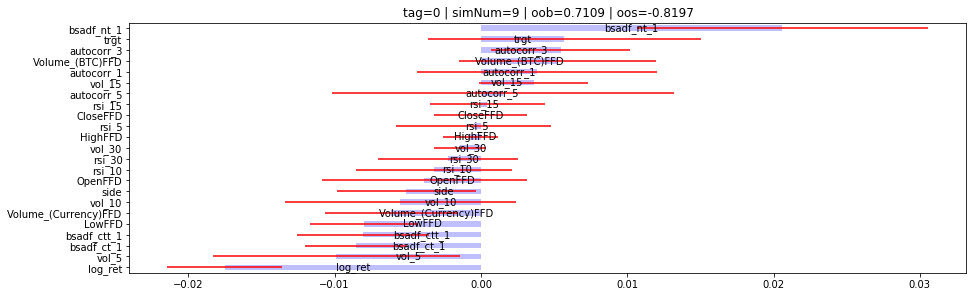

In [96]:
plotFeatImp(None, imp_mda, oob_mda, oos_mda, 'MDA')

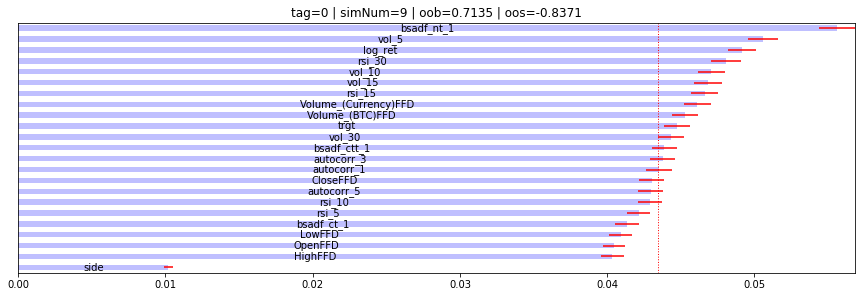

In [97]:
plotFeatImp(None, imp_mdi, oob_mdi, oos_mdi, 'MDI')

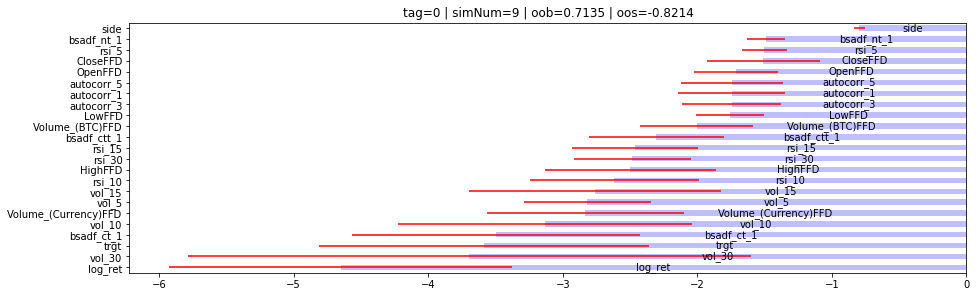

In [98]:
plotFeatImp(None, imp_sfi, oob_sfi, oos_sfi, 'SFI')

## Metricas financieras

In [99]:
Xx = Xy.copy()[features]
yy = Xy.copy().bin
X_trainn, X_testt, y_trainn, y_testt = train_test_split(Xx, yy, test_size=0.5, shuffle=False)

/home/agustin/anaconda3/lib/python3.7/site-packages/empyrical/stats.py:1494: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()


Start date,2016-11-23
End date,2020-12-12
Total months,9
,Backtest
Annual return,-100.0%
Cumulative returns,-100.0%
Annual volatility,542.5%
Sharpe ratio,-4.79
Calmar ratio,-0.99
Stability,NaN
Max drawdown,-100.9%


/home/agustin/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,100.92,2016-11-30,2018-01-29,NaT,NaN
1,0.00,2016-11-23,2016-11-23,2016-11-23,1
2,0.00,2016-11-23,2016-11-23,2016-11-23,1
3,0.00,2016-11-23,2016-11-23,2016-11-23,1
4,0.00,2016-11-23,2016-11-23,2016-11-23,1


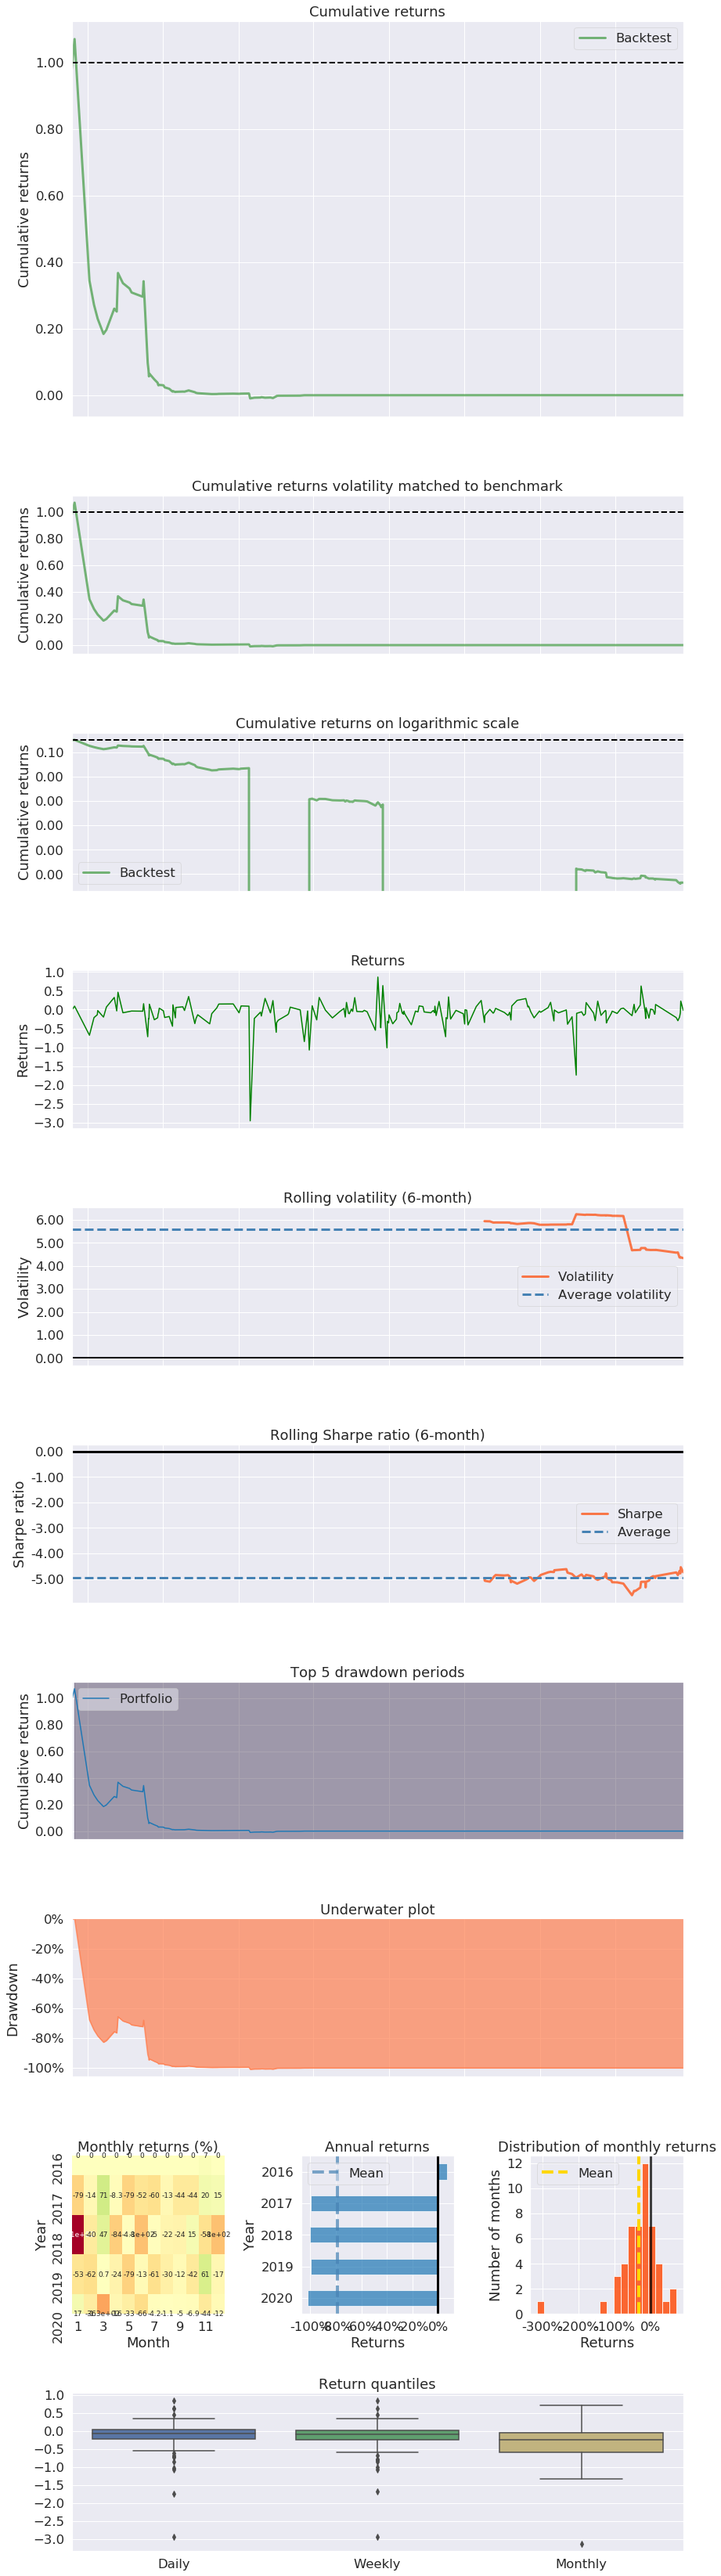

In [100]:
test_dates = X_testt.index
pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)

Start date,2016-11-23
End date,2020-12-12
Total months,9
,Backtest
Annual return,-99.8%
Cumulative returns,-99.0%
Annual volatility,253.0%
Sharpe ratio,-0.75
Calmar ratio,-1.01
Stability,0.69
Max drawdown,-99.2%


/home/agustin/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,99.23,2016-11-30,2020-12-05,NaT,NaN
1,0.00,2016-11-23,2016-11-23,2016-11-23,1
2,0.00,2016-11-23,2016-11-23,2016-11-23,1
3,0.00,2016-11-23,2016-11-23,2016-11-23,1
4,0.00,2016-11-23,2016-11-23,2016-11-23,1


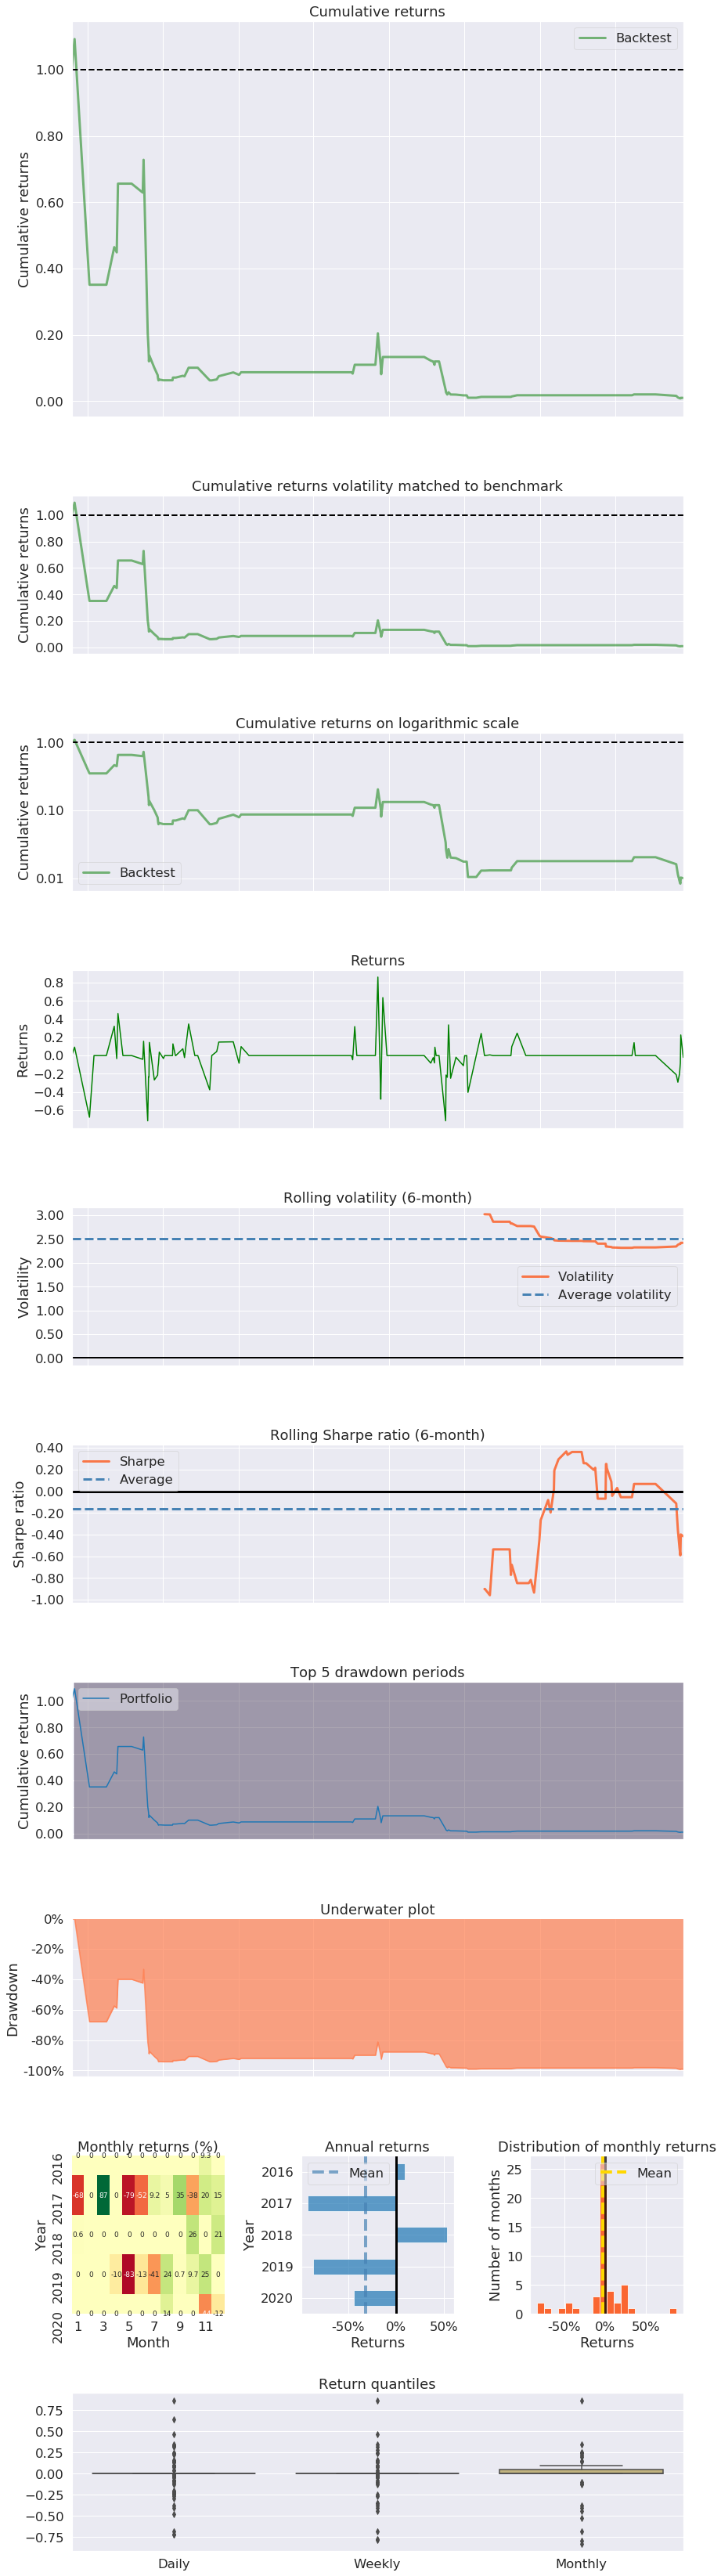

In [101]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred_rsrf
pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None)